**INTRODUCTION**:                                                                                                          
False 911 calls are not only a waste of resources, but take resources away from real emergencies. **In this binary classification model**, I try to predict false 911 calls (i.e calls without merit) by analyzing a log of close to 300,000 911 emergency phone calls made in the city of San Francisco in 2018 which I obtained from this **[website](https://data.sfgov.org/browse?category=Public+Safety)**. The dataset consists primarily of categorical features with high cardinality and the target class was highly imbalanced. While analyzing response time, I noticed that the dataset contains many outliers. After cleaning the dataset, I obtained an understanding of the relationship between features by means of visualization and statistical measures (chi-squared, R2 ). Furthermore, because I wanted to lower Type II error, or False Negatives, I used the "recall" score to evaluate various statistical models used in predicting 911 calls with no merit ("False 911 calls"). Ultimately, after applying dimension reduction techniques, I settled on a logistic regression model with a recall score of 85%. Along my analysis of the data, I came across very interesting findings:

- After removing outliers, the average response time for a call was approximately 8 minutes with a standard deviation of 3 minutes (cell 27). However, an interesting note to consider is that after removing low-calling neighborhoods (making up a combined 20% of calls), the response time remained the same but the standard deviation went down to about 30 seconds – implying that a vast majority of calls (closer to 80%) come from the same geographical area. (cell 28)
- Though there is a weak relationship between timing/seasonality of the calls, the response time is consistent regardless of time of day/day of week/season of year (cells 30 - 32).
- Of the 40 neighborhoods in San Francisco, approximately 50% of the calls came from 5 neighborhoods (cell 28) which in turn made up approximately 50% of False 911 calls (cell 34)
- A large majority of calls were for medical reasons (cell 30).
- The largest percentage of False 911 calls from a single neighborhood was 14% (cell 35)




**1. Dataset**                                                                                                 
**2. Data Cleaning and Feature Engineering**     
A. Data types and missing data                    
B. Feature Engineering                                               
**3. Analysis of Frequency and Response Time of 911 calls**     
A. Outliers         
B. Response Time Per Neighborhood    
C. Frequency of Call_Types and Response Time                                                                                 
D. Response Time Per Season                                                                                  
E. Response Time During the Day                                                                                            
F. Response Time During the Week                                                                                              
**4. Analysis of False 911 calls**                                                                                        
A. False Calls By Neighborhood                                                                                            
B. Percentage of False Calls By Neighborhood                                                                                
C. Frequency of False Calls by Time                                                                                             
**5. Analysis of Coordinates**    
**6. Analysis of Target Distribution**    
**7. Statistical Analysis of Categorical Features to Target**    
**8. Modeling**          
A. Balancing Target Classes
B. Baseline                                              
C. Bagging Algorithm (Random Forest) (Parallel Learners)                                               
D. Boosting Algorithm (Gradient Boosting)  (Serial Learners)                                
E. Feature Importance  
F. Logistic Regression (after Feature extraction)                                         
**9. Conclusion**           
A. Winner

## Libraries

In [1]:
#importing related libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as sc
from scipy import stats
from math import floor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2


import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score


import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### 1. Dataset

In [2]:
fire_df=pd.read_csv(r'C:\Users\admin\Desktop\Fire_Department_Calls_for_Service-2018.csv',na_values='None')

In [3]:
print(fire_df.shape)
fire_df.head()

(283067, 34)


,Call Number,Unit ID,Incident Number,Call Type,Call Date,Watch Date,Received DtTm,Entry DtTm,Dispatch DtTm,Response DtTm,On Scene DtTm,Transport DtTm,Hospital DtTm,Call Final Disposition,Available DtTm,Address,City,Zipcode of Incident,Battalion,Station Area,Box,Original Priority,Priority,Final Priority,ALS Unit,Call Type Group,Number of Alarms,Unit Type,Unit sequence in call dispatch,Fire Prevention District,Supervisor District,Neighborhooods - Analysis Boundaries,Location,RowID
0,180014109,T10,18000491,Alarms,1/1/2018,1/1/2018,1/1/2018 23:00,1/1/2018 23:02,1/1/2018 23:03,1/1/2018 23:04,NaN,NaN,NaN,Fire,1/1/2018 23:20,1000 Block of GIRARD RD,Presidio,94129.0,B99,51,4612,3,3,3,False,Alarm,1,TRUCK,3,7.0,2.0,Presidio,"(37.801325129454, -122.453498244358)",180014109-T10
1,180021641,T07,18000676,Alarms,1/2/2018,1/2/2018,1/2/2018 12:01,1/2/2018 12:03,1/2/2018 12:03,NaN,NaN,NaN,NaN,Fire,1/2/2018 12:07,900 Block of DE HARO ST,San Francisco,94107.0,B10,37,2511,3,3,3,False,Alarm,1,TRUCK,3,10.0,10.0,Potrero Hill,"(37.758937051159, -122.400966701986)",180021641-T07
2,180030264,87,18000955,Medical Incident,1/3/2018,1/2/2018,1/3/2018 2:34,1/3/2018 2:35,1/3/2018 2:37,1/3/2018 2:37,1/3/2018 2:42,1/3/2018 2:57,1/3/2018 3:02,Code 2 Transport,1/3/2018 3:50,200 Block of WOODSIDE AVE,San Francisco,94131.0,B08,39,8645,3,3,3,True,Potentially Life-Threatening,1,MEDIC,1,8.0,7.0,Twin Peaks,"(37.745956295386, -122.454239907613)",180030264-87
3,180030369,60,18000972,Medical Incident,1/3/2018,1/2/2018,1/3/2018 4:15,1/3/2018 4:17,1/3/2018 4:19,1/3/2018 4:19,1/3/2018 4:29,1/3/2018 4:36,1/3/2018 4:58,Code 2 Transport,1/3/2018 5:30,100 Block of CORA ST,San Francisco,94134.0,B09,44,6253,2,2,2,True,Non Life-threatening,1,MEDIC,1,9.0,10.0,Visitacion Valley,"(37.710878454701, -122.409122191393)",180030369-60
4,180030299,79,18000960,Medical Incident,1/3/2018,1/2/2018,1/3/2018 3:06,1/3/2018 3:06,1/3/2018 3:07,1/3/2018 3:07,1/3/2018 3:11,1/3/2018 3:23,1/3/2018 3:35,Code 2 Transport,1/3/2018 4:16,600 Block of TAYLOR ST,San Francisco,94109.0,B01,3,1451,C,3,3,True,Potentially Life-Threatening,1,MEDIC,1,1.0,3.0,Nob Hill,"(37.788315869512, -122.41185546654)",180030299-79


In [4]:
#Target value_count

fire_df["Call Final Disposition"].value_counts().sort_values(ascending=False)

Code 2 Transport              140603
Fire                           71984
Patient Declined Transport     15575
No Merit                       14383
Code 3 Transport               13345
Cancelled                       6596
Against Medical Advice          5740
Unable to Locate                5182
Medical Examiner                3361
Other                           3104
SFPD                            1717
Gone on Arrival                 1284
CHP                               91
Duplicate                         70
Multi-casualty Incident           32
Name: Call Final Disposition, dtype: int64

In [5]:
#Categorizing/Binarizing the target

fire_df["Calls_WO_Merit"]=np.where((fire_df["Call Final Disposition"]=="No Merit") | (fire_df["Call Final Disposition"]=="Cancelled") | (fire_df["Call Final Disposition"]=="Unable to Locate"),1,0)

fire_df=fire_df.drop("Call Final Disposition",axis=1)

In [6]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283067 entries, 0 to 283066
Data columns (total 34 columns):
Call Number                             283067 non-null int64
Unit ID                                 283067 non-null object
Incident Number                         283067 non-null int64
Call Type                               283067 non-null object
Call Date                               283067 non-null object
Watch Date                              283067 non-null object
Received DtTm                           283067 non-null object
Entry DtTm                              283067 non-null object
Dispatch DtTm                           283067 non-null object
Response DtTm                           275735 non-null object
On Scene DtTm                           228986 non-null object
Transport DtTm                          82074 non-null object
Hospital DtTm                           80883 non-null object
Available DtTm                          283023 non-null object
Address    

## 2. Data Cleaning and Feature Engineering

### 2A. Data Types and Missing Values

In [7]:
time=["Received DtTm","Entry DtTm","Dispatch DtTm","Response DtTm","On Scene DtTm","Transport DtTm","Hospital DtTm","Available DtTm"]

for column in time:
    fire_df[column]=fire_df[column].astype('datetime64[ns]')

In [8]:
# converting coordinates to numerical

Long_Lat=fire_df["Location"].str.split(",",expand=True)
Long=Long_Lat[0].str.strip("(")
fire_df["Longitude"]=pd.to_numeric(Long)

Lat=Long_Lat[1].str.strip(")")
fire_df["Latitude"]=pd.to_numeric(Lat)

fire_df=fire_df.drop("Location",axis=1)

In [9]:
fire_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283067 entries, 0 to 283066
Data columns (total 35 columns):
Call Number                             283067 non-null int64
Unit ID                                 283067 non-null object
Incident Number                         283067 non-null int64
Call Type                               283067 non-null object
Call Date                               283067 non-null object
Watch Date                              283067 non-null object
Received DtTm                           283067 non-null datetime64[ns]
Entry DtTm                              283067 non-null datetime64[ns]
Dispatch DtTm                           283067 non-null datetime64[ns]
Response DtTm                           275735 non-null datetime64[ns]
On Scene DtTm                           228986 non-null datetime64[ns]
Transport DtTm                          82074 non-null datetime64[ns]
Hospital DtTm                           80883 non-null datetime64[ns]
Available DtTm    

In [10]:
# Summary of Missing Values

def Missing_Values(df):
    Missing_Summary=df.isnull().sum().to_frame()
    Missing_Summary=Missing_Summary.rename(columns={0:"Missing_Values"})
    Missing_Summary["Percentage_of_Column_Missing"]=Missing_Summary["Missing_Values"]/len(df)
    Missing_Summary=Missing_Summary[Missing_Summary["Missing_Values"]>0].sort_values("Percentage_of_Column_Missing",ascending=False)
    return Missing_Summary

Missing_Values(fire_df)

,Missing_Values,Percentage_of_Column_Missing
Hospital DtTm,202184,0.714262
Transport DtTm,200993,0.710055
On Scene DtTm,54081,0.191054
Response DtTm,7332,0.025902
Fire Prevention District,2485,0.008779
City,549,0.001939
Neighborhooods - Analysis Boundaries,274,0.000968
Zipcode of Incident,208,0.000735
Supervisor District,198,0.000699
Call Type Group,153,0.000541


In [11]:
#Dropping features, rows with missing data based on given thresholds


Dropna_Threshold=.05             #Droppping rows where Percentage of Column that's missing is Less the threshold amount 
Drop_column_Threshold=.70         #Droppping columns where Percentage of Column that's missing is over the threshold amount
           

for col in fire_df.columns: 
    Null_Percentage=fire_df[col].isnull().sum()/len(fire_df)
    
    Imputation_Threshold=Dropna_Threshold <= Null_Percentage <= Drop_column_Threshold
    
    if Imputation_Threshold:
        pass
       # fire_df[col].fillna(value=fire_df[col].mean(),inplace=True)
    
    elif Null_Percentage < Dropna_Threshold:
        fire_df.dropna(subset=[col],inplace=True,axis=0) 
    
    elif Null_Percentage > Drop_column_Threshold:
        fire_df=fire_df.drop(col,axis=1) 
        

In [12]:
# Based on "domain" knowledge, dropping features that are not relevant to target

dropped_features=["Station Area","Original Priority","ALS Unit","Unit ID","Number of Alarms","Unit sequence in call dispatch","Fire Prevention District","Supervisor District","Call Number","Incident Number","RowID","Call Date","Watch Date","Entry DtTm","Dispatch DtTm","Response DtTm","Available DtTm","Address","City","Zipcode of Incident","Battalion","Priority","Final Priority","Box","Unit Type","Call Type Group"]
fire_df1=fire_df.drop(dropped_features,axis=1)


**Basis for dropped features:** 
- **"Unit ID" , "Call Number" , "Incident Number" , "RowID"**
    - internal records that served no purpose for prediction purposes
- **"Call Date" , "Watch Date" , "Entry DtTm" , "Dispatch DtTm", "Available DtTm"**
    - For exploratory purposes, we have kept the "Received DtTm" and "On Scene DtTm" columns. We will perform feature engineering techniques on these two columns. Other timestamp features provide no additional value. 
- **"Address", "City" , "Zipcode of Incident"**
    - For exploratory purposes, we have kepth the "Neighborhooods - Analysis Boundaries" and "Location" columns. "Location" would be most useful to us as we can split the coordinates and treat it as a continous feature.  All other columns provide no additional value w/ respect to the geographical area of the calls. 
- **"Battalion" , "Priority" , "Final Priority" , "Box" , "Unit Type"**
    - These features relate to action taken AFTER the call was received - as such, these features should not / can not be taken into account for the purpose of our objective
- **Station Area**,**Fire Prevention District** and **Supervisor District**
    - These features convey the same general underlying information of the jurisdiction covering the call - and therefore dropped from the dataset
- **Original Priority**,**Unit sequence in call dispatch**
    - These freatures do not convey any information w respect to whether the call is of merit or without
- **Call Type Group**
     - We maintained "Call Type" so therefore, Call Type Group is redundant
    

In [13]:
fire_df1.head()

,Call Type,Received DtTm,On Scene DtTm,Neighborhooods - Analysis Boundaries,Calls_WO_Merit,Longitude,Latitude
0,Alarms,2018-01-01 23:00:00,NaT,Presidio,0,37.801325,-122.453498
2,Medical Incident,2018-01-03 02:34:00,2018-01-03 02:42:00,Twin Peaks,0,37.745956,-122.454240
3,Medical Incident,2018-01-03 04:15:00,2018-01-03 04:29:00,Visitacion Valley,0,37.710878,-122.409122
4,Medical Incident,2018-01-03 03:06:00,2018-01-03 03:11:00,Nob Hill,0,37.788316,-122.411855
5,Medical Incident,2018-01-03 02:15:00,2018-01-03 02:31:00,Bayview Hunters Point,0,37.729302,-122.390877


### 2B. Feature Engineering

In [14]:
# converting string datatype to timestamp 


#retrieving hour of day
fire_df1["Hour_of_Day"]=fire_df1["Received DtTm"].dt.hour

#retrieving weekday name
fire_df1["WeekDay"]=fire_df1["Received DtTm"].dt.weekday_name


#retrieving month of year
fire_df1["Month_of_Year"]=fire_df1["Received DtTm"].dt.month


#Calculating response time
fire_df1["Response_Time"]=fire_df1["On Scene DtTm"] - fire_df1["Received DtTm"] 

#Imputing mean in place of missing values
fire_df1["Response_Time"].fillna(value=fire_df1["Response_Time"].mean(),inplace=True)

#converting from seconds to minutes
fire_df1["Response_Time"]=fire_df1["Response_Time"].dt.seconds/60








In [15]:
#converting time in decimal to time in minutes

def time_in_mins(x):
    time_minutes = x
    time_seconds = time_minutes * 60
    minutes = floor(time_minutes % 60)
    seconds = floor(time_seconds % 60)
    return float(f'{minutes}.{seconds}')


fire_df1["Response_Time"] = fire_df1["Response_Time"].apply(time_in_mins)

In [16]:
#Dropping Call and Arrival time since we already engineered this column
Dropped_Columns = ["Received DtTm","On Scene DtTm"]

fire_df1=fire_df1.drop(Dropped_Columns,axis=1)

In [17]:
# converting months of year to seasons (Fall, Summer, Winter, Spring) 

conditions=[fire_df1["Month_of_Year"].between(1,3),fire_df1["Month_of_Year"].between(3.01,6),fire_df1["Month_of_Year"].between(6.01,9),fire_df1["Month_of_Year"].between(9.01,12)]

Result=["Winter","Spring","Summer","Fall"]

fire_df1["Seasons"]=np.select(conditions,Result,default="Summer")      

fire_df1=fire_df1.drop("Month_of_Year",axis=1)

In [18]:
# converting hours of day to time segments (midnight to 4am=Late Night,  4-8=morning  and etc)

conditions=[fire_df1["Hour_of_Day"].between(0,4),fire_df1["Hour_of_Day"].between(4.01,8),fire_df1["Hour_of_Day"].between(8.01,12),fire_df1["Hour_of_Day"].between(12.01,16),fire_df1["Hour_of_Day"].between(16.01,20),fire_df1["Hour_of_Day"].between(20.01,24)]

Result=["Late_Night","Morning","Late_Morning","Afternoon","Evening","NightTime"]

fire_df1["Time_of_Day"]=np.select(conditions,Result,default="Afternoon")      

fire_df1=fire_df1.drop("Hour_of_Day",axis=1)




In [19]:
# Bifurcating continous and categorical features (including numerical features that are categorical)


categorical_columns=fire_df1.select_dtypes(include="object").columns.tolist()
numerical_columns=fire_df1.select_dtypes(exclude="object").columns.tolist()

#numerical features that are actually categorical
num_to_cat_columns=['Calls_WO_Merit']  


categorical_columns.extend(num_to_cat_columns)
numerical_columns=list(set(numerical_columns).difference(set(num_to_cat_columns)))


print("Categorical Features")
print(categorical_columns)
print("*"*75)
print("Numerical Features")
print(numerical_columns)

Categorical Features
['Call Type', 'Neighborhooods - Analysis Boundaries', 'WeekDay', 'Seasons', 'Time_of_Day', 'Calls_WO_Merit']
***************************************************************************
Numerical Features
['Longitude', 'Latitude', 'Response_Time']


In [20]:
# printing number of unique values and value_count percentage for each categorical feature

for each_column in categorical_columns:
    print("*"*100)
    print("There are " + str(fire_df1[each_column].nunique()) +" unique values of the " + '"{}" feature. Percentages of its value counts is listed below.'.format(each_column).format(each_column))
    print("*"*100)
    print(fire_df1[each_column].value_counts()/len(fire_df1))
    print("*"*100)

****************************************************************************************************
There are 27 unique values of the "Call Type" feature. Percentages of its value counts is listed below.
****************************************************************************************************
Medical Incident                                0.690248
Alarms                                          0.115065
Structure Fire                                  0.085896
Traffic Collision                               0.042123
Outside Fire                                    0.014582
Citizen Assist / Service Call                   0.013468
Other                                           0.013090
Gas Leak (Natural and LP Gases)                 0.005562
Water Rescue                                    0.004382
Electrical Hazard                               0.003304
Vehicle Fire                                    0.003179
Elevator / Escalator Rescue                     0.003065
Smoke Inve

In [21]:
# Summarizing Call Type 27 unique values into 6 "buckets". KeepingTop 5 Call Types as they make up 95% of calls. Remaining 22 Call Types being bucketed into "All other".

Top5_Call_Type=fire_df1["Call Type"].value_counts().index[:5]

Call_Type=[]
for value in fire_df1["Call Type"]: #.value_counts().index:
    if value not in Top5_Call_Type:
        Call_Type.append("All other < ~5%")
    else:
        Call_Type.append(value)


fire_df1["Call Type"]=Call_Type

In [22]:
# Summarizing Neighborhood 40 unique values into 19 "buckets", capturing 80% of the data. The remaining 20% will be captured in "Other".

Top20_Neighborhoods=fire_df1["Neighborhooods - Analysis Boundaries"].value_counts().index[:19]

Neighborhoods=[]
for value in fire_df1["Neighborhooods - Analysis Boundaries"]: #.value_counts().index:
    if value not in Top20_Neighborhoods:
        Neighborhoods.append("All other < ~20%")
    else:
        Neighborhoods.append(value)


fire_df1["Neighborhooods - Analysis Boundaries"]=Neighborhoods

In [23]:
for each_column in categorical_columns:
    print("*"*75)
    print("There are " + str(fire_df1[each_column].nunique()) +" unique values of feature " + '"{}"'.format(each_column))

***************************************************************************
There are 6 unique values of feature "Call Type"
***************************************************************************
There are 20 unique values of feature "Neighborhooods - Analysis Boundaries"
***************************************************************************
There are 7 unique values of feature "WeekDay"
***************************************************************************
There are 4 unique values of feature "Seasons"
***************************************************************************
There are 6 unique values of feature "Time_of_Day"
***************************************************************************
There are 2 unique values of feature "Calls_WO_Merit"


In [24]:
fire_df1.head()

,Call Type,Neighborhooods - Analysis Boundaries,Calls_WO_Merit,Longitude,Latitude,WeekDay,Response_Time,Seasons,Time_of_Day
0,Alarms,All other < ~20%,0,37.801325,-122.453498,Monday,9.25,Winter,NightTime
2,Medical Incident,All other < ~20%,0,37.745956,-122.454240,Wednesday,8.00,Winter,Late_Night
3,Medical Incident,All other < ~20%,0,37.710878,-122.409122,Wednesday,14.00,Winter,Late_Night
4,Medical Incident,Nob Hill,0,37.788316,-122.411855,Wednesday,5.00,Winter,Late_Night
5,Medical Incident,Bayview Hunters Point,0,37.729302,-122.390877,Wednesday,16.00,Winter,Late_Night


## 3. Analysis of Frequency and Response Time of 911 calls

### 3A. Handing outliers

Analysis:

Visually, there are many data points that seem to be outliers. Also, there may be some bad data as well as some response time ranges from 20 to 60 minutes - which just does not make sense. Hence, we will remove these outliers in the next step.


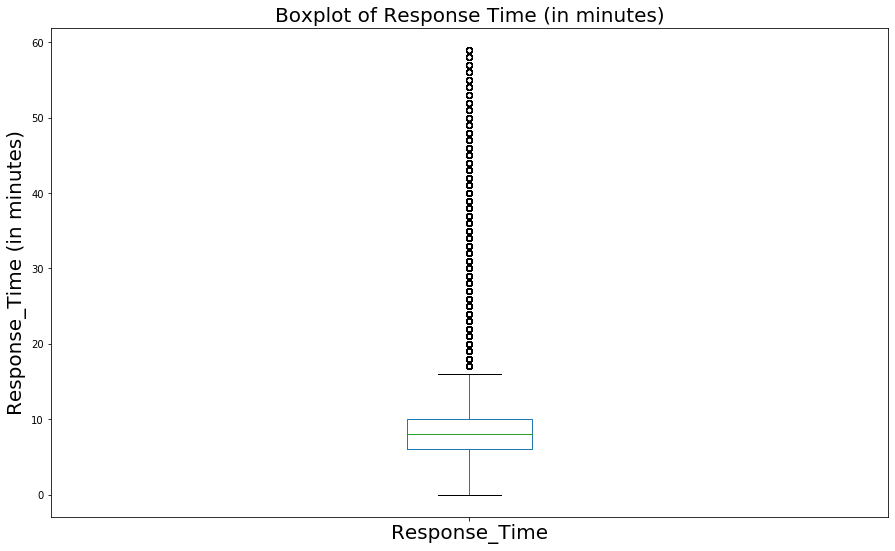

In [25]:
plt.figure(figsize=(15,9))
print('Analysis:\n\nVisually, there are many data points that seem to be outliers. Also, there may be some bad data as well as some response time ranges from 20 to 60 minutes - which just does not make sense. Hence, we will remove these outliers in the next step.')

fire_df1["Response_Time"].plot("box")
plt.title("Boxplot of Response Time (in minutes)",fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel('Response_Time (in minutes)',fontsize=20)
plt.show()

**Removing outliers** using IQR

In [26]:
Basic_Stats=fire_df1["Response_Time"].describe()

Q3 = Basic_Stats.loc["75%"]
Q1 = Basic_Stats.loc["25%"]

#IQR
IQR = Q3 - Q1
LB = Q1 - (IQR * 1.5)
UB = Q3 + (IQR * 1.5)

#Outliers
Response_Outliers_Df=fire_df1[(fire_df1["Response_Time"]<=LB) | (fire_df1["Response_Time"]>UB)]

#DF_wo_Outliers
Response_Df=fire_df1.loc[~fire_df1.index.isin(Response_Outliers_Df.index),:]

Response_Df.head()

,Call Type,Neighborhooods - Analysis Boundaries,Calls_WO_Merit,Longitude,Latitude,WeekDay,Response_Time,Seasons,Time_of_Day
0,Alarms,All other < ~20%,0,37.801325,-122.453498,Monday,9.25,Winter,NightTime
2,Medical Incident,All other < ~20%,0,37.745956,-122.454240,Wednesday,8.00,Winter,Late_Night
3,Medical Incident,All other < ~20%,0,37.710878,-122.409122,Wednesday,14.00,Winter,Late_Night
4,Medical Incident,Nob Hill,0,37.788316,-122.411855,Wednesday,5.00,Winter,Late_Night
5,Medical Incident,Bayview Hunters Point,0,37.729302,-122.390877,Wednesday,16.00,Winter,Late_Night


**Comparing Basic Stats of "Response Time" feature Before and After removing outliers**

Below is quick stats on the response time before and after removing outliers. Notice, the average response time went down from 9.25 to 7.94. In addition, the standard deviation went down from 5.76 to 2.96.

Stats on 911 Response Time:

       Before_Removing_Outliers  After_Removing_Outliers
count             272725.000000            246288.000000
mean                   9.251534                 7.936012
std                    5.763337                 2.955909
min                    0.000000                 1.000000
25%                    6.000000                 6.000000
50%                    8.000000                 8.000000
75%                   10.000000                 9.250000
max                   59.000000                16.000000
*******************************************************
Analysis:
Notice that after removing outliers, the response time is normally distributed.


Text(0, 0.5, 'PDF')

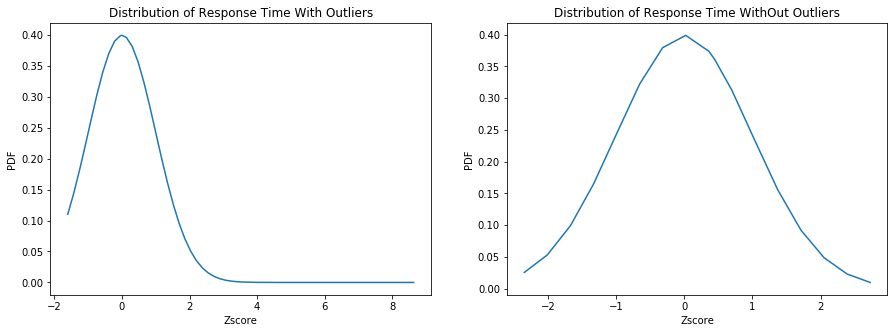

In [27]:
#creating dataframe
Response_stats_df=pd.DataFrame(Basic_Stats.values,index=Basic_Stats.index)
Response_stats_df.rename(columns={0: "Before_Removing_Outliers"},inplace=True)
Response_stats_df["After_Removing_Outliers"]=Response_Df["Response_Time"].describe()

std=round(Response_stats_df.loc['std','After_Removing_Outliers'],2)

print(f"Below is quick stats on the response time before and after removing outliers. Notice, the average response time went down from {round(Response_stats_df.loc['mean','Before_Removing_Outliers'],2)} to {round(Response_stats_df.loc['mean','After_Removing_Outliers'],2)}. In addition, the standard deviation went down from {round(Response_stats_df.loc['std','Before_Removing_Outliers'],2)} to {std}.\n\nStats on 911 Response Time:\n")

print(Response_stats_df)
      
print("*"*55)

print("Analysis:\nNotice that after removing outliers, the response time is normally distributed.")      

      
#plotting      
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)      
Response_Time_w_Outliers = stats.zscore(fire_df1["Response_Time"].sort_values())
pdf_w_outliers = stats.norm.pdf(Response_Time_w_Outliers, Response_Time_w_Outliers.mean(), Response_Time_w_Outliers.std())         
plt.plot(Response_Time_w_Outliers, pdf_w_outliers)       
plt.title('Distribution of Response Time With Outliers')      
plt.xlabel("Zscore")      
plt.ylabel("PDF")    
     
      
plt.subplot(1, 2, 2)           
Response_Time_wo_Outliers = stats.zscore(Response_Df['Response_Time'].sort_values())    
pdf_wo_outliers = stats.norm.pdf(Response_Time_wo_Outliers, Response_Time_wo_Outliers.mean(), Response_Time_wo_Outliers.std())
plt.plot(Response_Time_wo_Outliers, pdf_wo_outliers)          
plt.title('Distribution of Response Time WithOut Outliers')     
plt.xlabel("Zscore")      
plt.ylabel("PDF")    


### 3B. Response Time Per Neighborhood

Analysis:
 Note that low-calling neighborhoods (making up ~20% of calls) were grouped into "Other" in Cell 23 and for comparative purposes, is not show below. Note that approximately 46.0% of the calls came from 5 neighborhoods.


Tenderloin                        34962
South of Market                   25730
Mission                           22051
Financial District/South Beach    18890
Bayview Hunters Point             12344
Name: Neighborhooods - Analysis Boundaries, dtype: int64


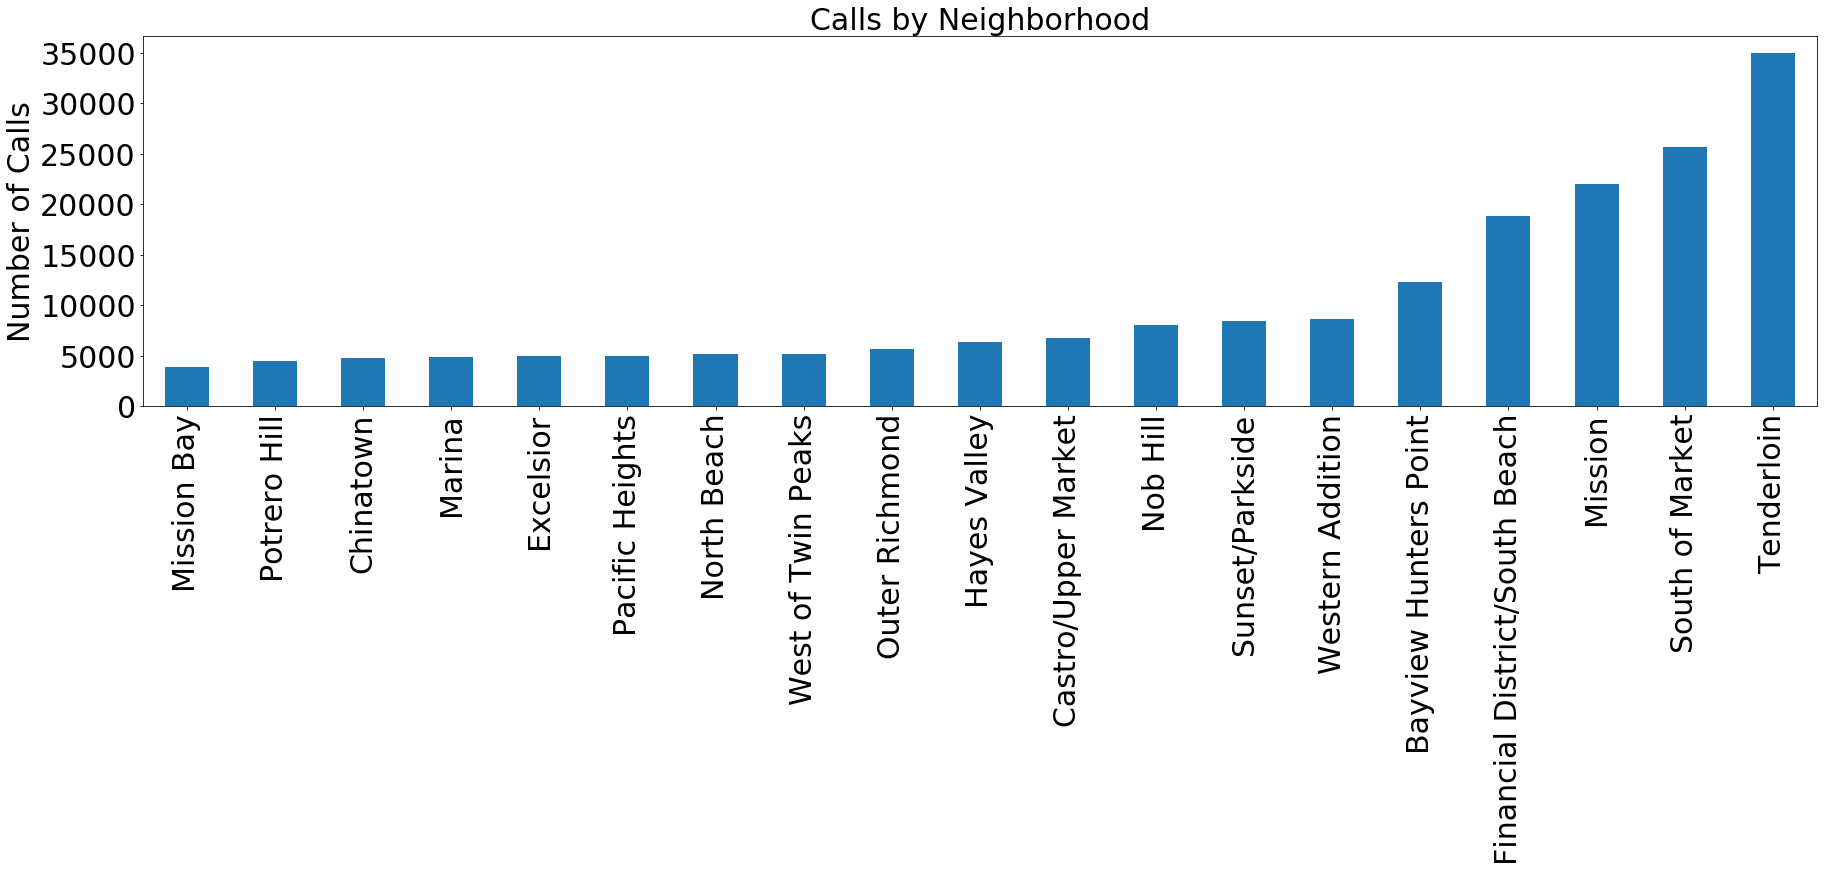

Analysis:
Below is a quick statistical summary of response time per neighborhood. There are 20 neighborhoods and the average time of response per neighborhood was approximately 7.91 with a standard deviation of only 0.33. Compare this standard deviation with the standard deviation of response time for the entire 40 neighborhoods as shown above - 2.96. This implies that the 911 response time is pretty much the same regardless of the neighborhood the call comes from.

count    20.000000
mean      7.914862
std       0.330153
min       7.306280
25%       7.621233
50%       7.991771
75%       8.122293
max       8.407668
Name: Response_Time, dtype: float64


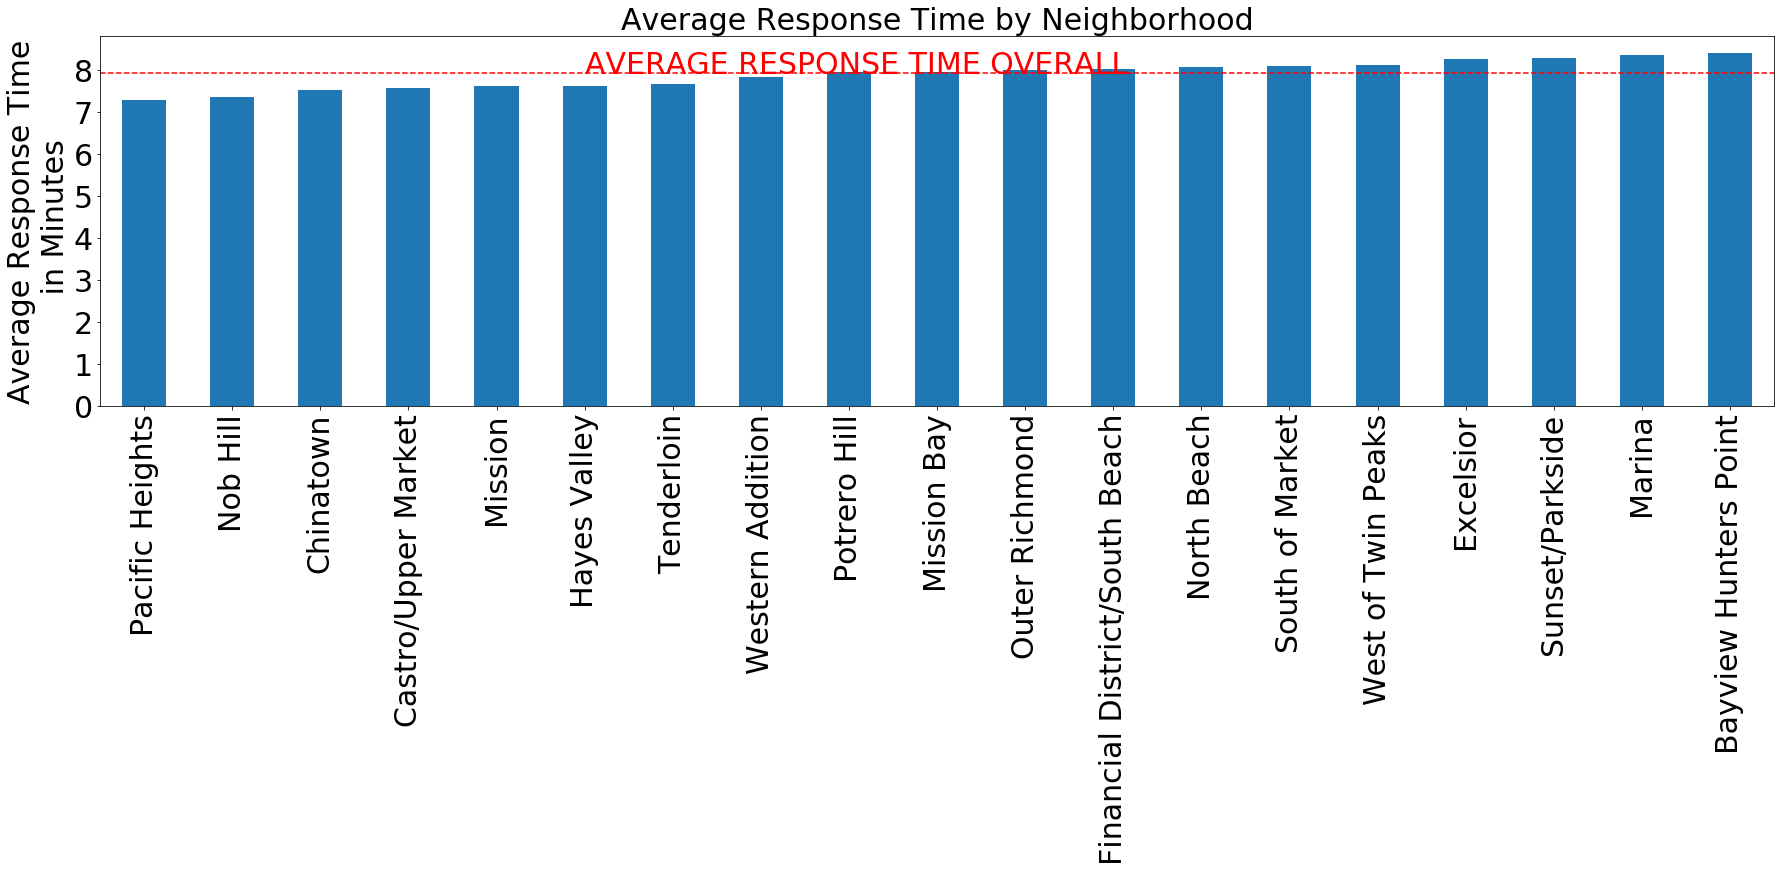

In [28]:

Top5_Nei = Response_Df['Neighborhooods - Analysis Boundaries'].value_counts(ascending=False)[1:6]


Top5=Response_Df['Neighborhooods - Analysis Boundaries'].value_counts(ascending=False)[1:6].sum()



Overall = Response_Df['Neighborhooods - Analysis Boundaries'].value_counts(ascending=False).sum()

All_Other=Response_Df['Neighborhooods - Analysis Boundaries'].value_counts(ascending=False)[0].sum()



print(f'Analysis:\n Note that low-calling neighborhoods (making up ~20% of calls) were grouped into "Other" in Cell 23 and for comparative purposes, is not show below. Note that approximately {round((Top5/Overall)*100,0)}% of the calls came from 5 neighborhoods.\n\n' )
print(Response_Df['Neighborhooods - Analysis Boundaries'].value_counts(ascending=False)[1:6].head())


plt.figure(figsize=(30,15))
plt.subplot(2, 1, 1)      

Response_Df["Neighborhooods - Analysis Boundaries"].value_counts(ascending=True).drop('All other < ~20%',axis=0).plot('bar')
plt.title("Calls by Neighborhood",fontsize=30)     
plt.xlabel('')   
plt.xticks(rotation=90,fontsize=30)
plt.ylabel('Number of Calls',fontsize=30)
plt.yticks(fontsize=30)
plt.show() 



#-----------------------------------------------------------------------------------------------------
      
Avg_Time=Response_Df["Response_Time"].mean()
Quickest=Response_Df["Response_Time"].min()
Latest=Response_Df["Response_Time"].max()  

float(str(Avg_Time)[-3:])
   
Avg_Response_Time_per_Neighborhood = Response_Df.groupby(["Neighborhooods - Analysis Boundaries"])["Response_Time"].mean().sort_values()

Avg_Response_wo_Other=Response_Df.groupby(["Neighborhooods - Analysis Boundaries"])["Response_Time"].mean().sort_values().drop('All other < ~20%',axis=0)      
      
#print(f"Analysis:\nBelow is a quick statistical summary of response time per neighborhood. There are {len(Avg_Response_Time_per_Neighborhood)} neighborhoods and the average time of response per neighborhood was approximately {round(Avg_Response_Time_per_Neighborhood.mean(),2)} with a standard deviation of only {round(Avg_Response_Time_per_Neighborhood.std(),2)}."# Compare this standard deviation with the standard deviation of response time for the entire 40 neighborhoods as shown above"# - {round(Response_stats_df.loc['std','After_Removing_Outliers'],2)}. This implies that the 911 response time is pretty much the same regardless of the neighborhood the call comes from.\n' )

print(f'Analysis:\nBelow is a quick statistical summary of response time per neighborhood. There are {len(Avg_Response_Time_per_Neighborhood)} neighborhoods and the average time of response per neighborhood was approximately {round(Avg_Response_Time_per_Neighborhood.mean(),2)} with a standard deviation of only {round(Avg_Response_Time_per_Neighborhood.std(),2)}. Compare this standard deviation with the standard deviation of response time for the entire 40 neighborhoods as shown above - {std}. This implies that the 911 response time is pretty much the same regardless of the neighborhood the call comes from.\n' )
print(f'{Avg_Response_Time_per_Neighborhood.describe()}')



plt.figure(figsize=(30,15))     
plt.subplot(2, 1, 2)           


g=Avg_Response_wo_Other.plot('bar')
g.text(5,Response_Df["Response_Time"].mean(),'AVERAGE RESPONSE TIME OVERALL',color='red',fontsize=30)
g.axhline(y=Response_Df["Response_Time"].mean(), color='red',ls='--')
plt.title("Average Response Time by Neighborhood",fontsize=30)
plt.xlabel('')  
plt.xticks(rotation=90,fontsize=30)
plt.ylabel('Average Response Time\n in Minutes',fontsize=30)
plt.yticks(fontsize=30)

plt.show() 

**Analysis of Top 5 Neighborhoods by Frequency of 911 calls made**

In [29]:
#Top_5_Neighborhoods_Df=Response_Df[Response_Df["Neighborhooods - Analysis Boundaries"].isin(Response_Df['Neighborhooods - Analysis Boundaries'].value_counts(ascending=False).head().index)]

Top_5_Neighborhoods_Df = Response_Df[Response_Df["Neighborhooods - Analysis Boundaries"].isin(Top5_Nei.index)]

Top_5_Neighborhoods_Df.head()

,Call Type,Neighborhooods - Analysis Boundaries,Calls_WO_Merit,Longitude,Latitude,WeekDay,Response_Time,Seasons,Time_of_Day
5,Medical Incident,Bayview Hunters Point,0,37.729302,-122.390877,Wednesday,16.00,Winter,Late_Night
8,Medical Incident,Financial District/South Beach,0,37.788342,-122.407575,Saturday,9.25,Winter,Afternoon
11,Alarms,Bayview Hunters Point,0,37.727658,-122.370592,Tuesday,8.00,Winter,Late_Morning
13,Medical Incident,Mission,1,37.764291,-122.418689,Thursday,10.00,Winter,Late_Morning
14,Alarms,Bayview Hunters Point,0,37.750075,-122.390928,Thursday,4.00,Winter,Late_Night


### 3C. Frequency of Call_Types and Response Time

Analysis: After narrowing the dataset to the 5 neighborhoods that make up close to 50% of the calls, we see that 1.0% of calls are for Medical Incident. In such situations, average response time is 8.15 minutes.

                   count      mean       std
Call Type                                   
Medical Incident   82476  8.153257  3.087553
Alarms             12901  7.053891  2.033434
Structure Fire      7967  7.032195  2.720132
All other < ~5%     4334  7.867155  2.608065
Traffic Collision   4215  7.596323  3.174589
Outside Fire        2084  7.254679  2.423062


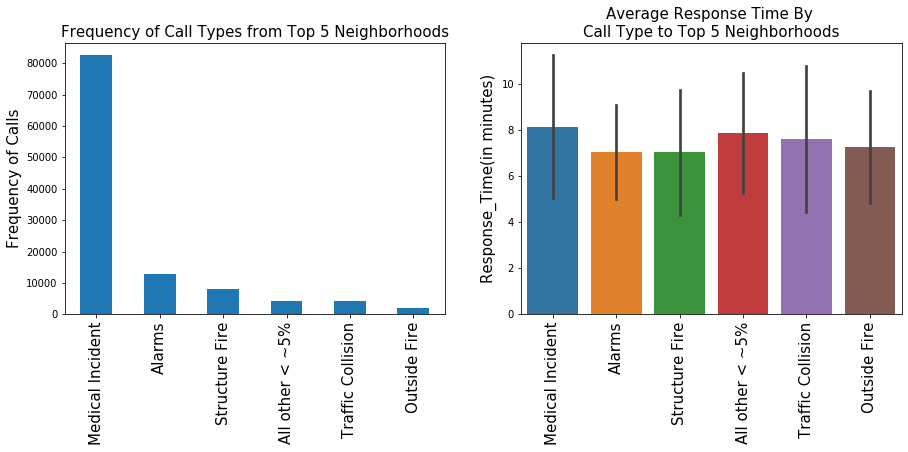

In [30]:
Avg_Response_Time_per_CallType = Top_5_Neighborhoods_Df.groupby(["Call Type"])["Response_Time"].agg(["count","mean","std"])

Count_Order = Avg_Response_Time_per_CallType.sort_values('count',ascending=False)

Medical_Per = Count_Order["count"].iloc[0]/Count_Order["count"].sum()

Most_Count=Avg_Response_Time_per_CallType.sort_values('count',ascending=False).head(1).index[0]

Most_Count_Mean=Avg_Response_Time_per_CallType.loc[Most_Count,'mean']

print(f"Analysis: After narrowing the dataset to the 5 neighborhoods that make up close to 50% of the calls, we see that {round(Medical_Per,0)}% of calls are for {Most_Count}. In such situations, average response time is {round(Most_Count_Mean,2)} minutes.\n")                                                                                  

print(Count_Order)

fig, axes = plt.subplots(1,2, figsize=(15, 5))

#sns.countplot("Call Type",data=Top_5_Neighborhoods_Df,ax=axes[0],hue='Calls_WO_Merit',color='b') 
#axes[0].legend(labels=["Merit Calls","Calls w/o Merit"])

Top_5_Neighborhoods_Df["Call Type"].value_counts().plot(kind='bar',ax=axes[0])
sns.barplot('Call Type','Response_Time',data=Top_5_Neighborhoods_Df,ci='sd',ax=axes[1],order=Top_5_Neighborhoods_Df["Call Type"].value_counts().index)

axes[0].set_title("Frequency of Call Types from Top 5 Neighborhoods",fontsize=15)
axes[0].set_ylabel("Frequency of Calls",fontsize=15)
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(),fontsize=15)

axes[1].set_title("Average Response Time By \nCall Type to Top 5 Neighborhoods",fontsize=15)
axes[1].set_ylabel("Response_Time(in minutes)",fontsize=15)
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(),fontsize=15,rotation=90)
axes[1].set_xlabel('')

#plt.xticks(rotation=90)

plt.show()

### 3D. Response Time Per Season

Analysis: Except for winter, the number of calls that come in are pretty consistent throughout the year. Average Time to respond to these calls is consistent throughout the year as well.


         count      mean       std
Seasons                           
Spring   31697  7.953339  2.949512
Fall     31098  7.884197  2.988708
Summer   30926  7.849108  2.979731
Winter   20256  7.932859  2.949272
***************************************************************************


<Figure size 1080x648 with 0 Axes>

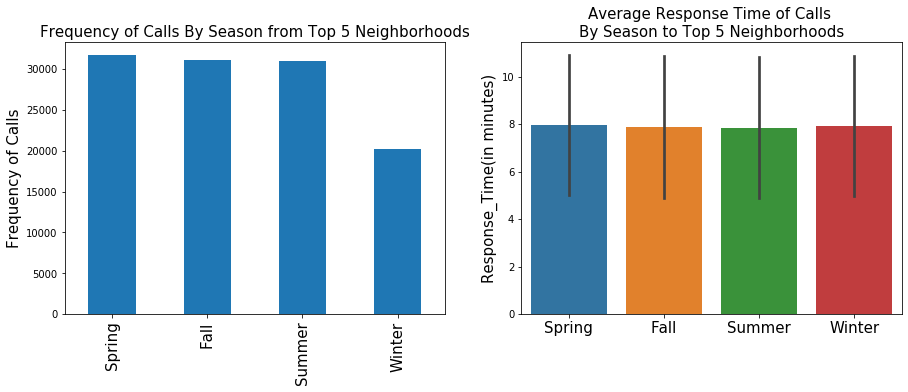

In [31]:
Avg_Response_Time_per_Season = Top_5_Neighborhoods_Df.groupby(["Seasons"])["Response_Time"].agg(["count","mean","std"])

print("Analysis: Except for winter, the number of calls that come in are pretty consistent throughout the year. Average Time to respond to these calls is consistent throughout the year as well.\n\n")                                                                                                
print(Avg_Response_Time_per_Season.sort_values('count',ascending=False))
print("*"*75)

plt.figure(figsize=(15,9))
fig, axes = plt.subplots(1,2, figsize=(15, 5))

#sns.countplot("Seasons",data=Top_5_Neighborhoods_Df,ax=axes[0],hue='Calls_WO_Merit',color='b') 
#axes[0].legend(labels=["Merit Calls","Calls w/o Merit"])

Top_5_Neighborhoods_Df["Seasons"].value_counts().plot(kind='bar',ax=axes[0])
sns.barplot('Seasons','Response_Time',data=Top_5_Neighborhoods_Df,ci='sd',ax=axes[1],order=Top_5_Neighborhoods_Df["Seasons"].value_counts().index)

axes[0].set_title("Frequency of Calls By Season from Top 5 Neighborhoods",fontsize=15)
axes[0].set_ylabel("Frequency of Calls",fontsize=15)
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(),fontsize=15)

axes[1].set_title("Average Response Time of Calls \nBy Season to Top 5 Neighborhoods",fontsize=15)
axes[1].set_ylabel("Response_Time(in minutes)",fontsize=15)
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(),fontsize=15)
axes[1].set_xlabel('')

plt.show()

### 3E. Response Time During the Day

Analysis: Most of the calls come in from late morning to evening (8:00AM - 8:00PM). Average Time is consistent throughout the Day. Average Time to respond is fastest in the night (8:00PM - 12:00AM) - presumbably because there is less traffic.

              count      mean       std
Time_of_Day                            
Afternoon     24881  7.858326  3.004631
Evening       23304  7.769600  3.010763
Late_Morning  22856  8.013727  3.005234
Late_Night    15471  8.039364  2.843122
NightTime     14474  7.666868  2.978400
Morning       12991  8.129821  2.860184
***************************************************************************


<Figure size 1080x648 with 0 Axes>

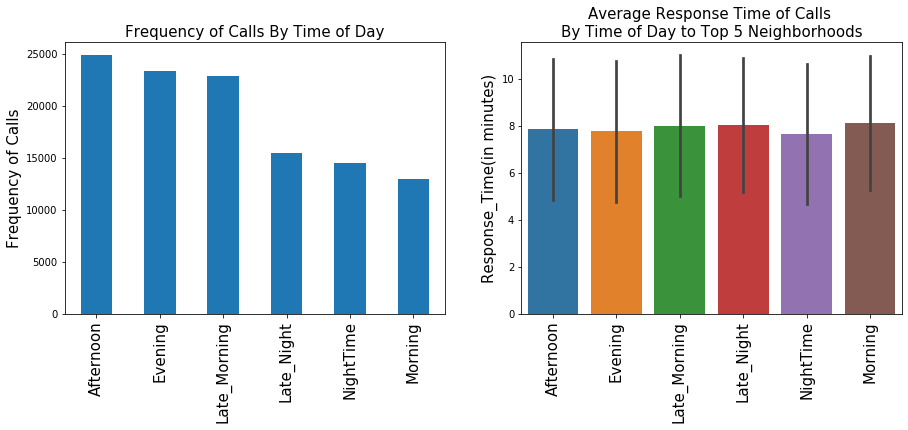

In [32]:
# 12:00AM - 4:00AM->LateNight,  
# 4:00AM - 8:00AM->Morning, 
# 8:00AM - 12:00AM->LateMorning,  
# 12:00PM - 4:00PM->Afternoon,
# 4:00PM - 8:00PM->Evening,
# 8:00PM - 12:00AM->NightTime

Avg_Response_Time_During_the_Day = Top_5_Neighborhoods_Df.groupby(["Time_of_Day"])["Response_Time"].agg(["count","mean","std"])

print("Analysis: Most of the calls come in from late morning to evening (8:00AM - 8:00PM). Average Time is consistent throughout the Day. Average Time to respond is fastest in the night (8:00PM - 12:00AM) - presumbably because there is less traffic.\n")        
print(Avg_Response_Time_During_the_Day.sort_values('count',ascending=False))
print("*"*75)


plt.figure(figsize=(15,9))
fig, axes = plt.subplots(1,2, figsize=(15, 5))


Top_5_Neighborhoods_Df["Time_of_Day"].value_counts().plot(kind='bar',ax=axes[0])
sns.barplot('Time_of_Day','Response_Time',data=Top_5_Neighborhoods_Df,ci='sd',ax=axes[1],order=Top_5_Neighborhoods_Df["Time_of_Day"].value_counts().index)

axes[0].set_title("Frequency of Calls By Time of Day",fontsize=15)
axes[0].set_ylabel("Frequency of Calls",fontsize=15)
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(),fontsize=15)

axes[1].set_title("Average Response Time of Calls \nBy Time of Day to Top 5 Neighborhoods",fontsize=15)
axes[1].set_ylabel("Response_Time(in minutes)",fontsize=15)
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(),fontsize=15,rotation=90)
axes[1].set_xlabel('')

plt.show()

### 3F. Response Time During the Week

Analysis:
 Friday receives the most number of calls. Average Time is consistent throughout the Week.


           count      mean       std
WeekDay                             
Friday     17031  7.900637  2.969952
Monday     16754  7.930270  3.009121
Thursday   16493  7.911220  2.974778
Wednesday  16447  7.995349  2.974858
Saturday   16023  7.833989  2.938074
Tuesday    15970  7.919239  2.950591
Sunday     15259  7.819402  2.956867
***************************************************************************


<Figure size 1080x648 with 0 Axes>

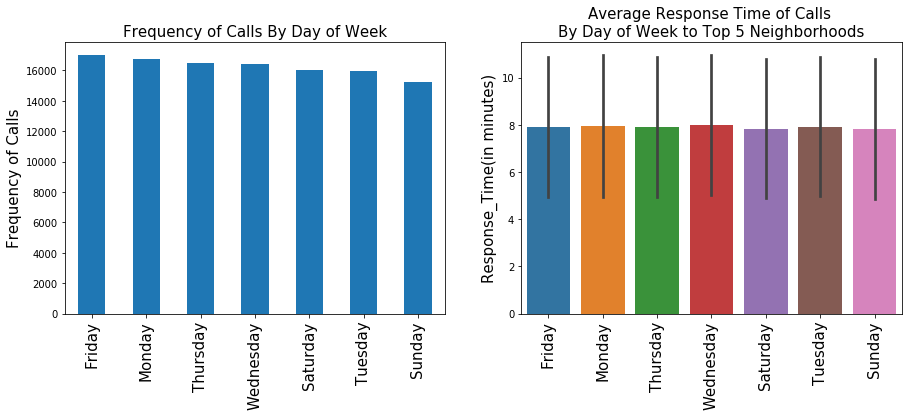

In [33]:
Avg_Response_Time_During_the_Week = Top_5_Neighborhoods_Df.groupby(["WeekDay"])["Response_Time"].agg(["count","mean","std"])

print("Analysis:\n Friday receives the most number of calls. Average Time is consistent throughout the Week.\n\n")                                                                                                
print(Avg_Response_Time_During_the_Week.sort_values('count',ascending=False))
print("*"*75)

plt.figure(figsize=(15,9))
fig, axes = plt.subplots(1,2, figsize=(15, 5))

#sns.countplot("WeekDay",data=Top_5_Neighborhoods_Df,ax=axes[0],hue='Calls_WO_Merit',color='b') 
#axes[0].legend(labels=["Merit Calls","Calls w/o Merit"])

Top_5_Neighborhoods_Df["WeekDay"].value_counts().plot(kind='bar',ax=axes[0])
sns.barplot('WeekDay','Response_Time',data=Top_5_Neighborhoods_Df,ci='sd',ax=axes[1],order=Top_5_Neighborhoods_Df["WeekDay"].value_counts().index)

axes[0].set_title("Frequency of Calls By Day of Week",fontsize=15)
axes[0].set_ylabel("Frequency of Calls",fontsize=15)
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(),fontsize=15)


axes[1].set_title("Average Response Time of Calls \nBy Day of Week to Top 5 Neighborhoods",fontsize=15)
axes[1].set_ylabel("Response_Time(in minutes)",fontsize=15)
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(),fontsize=15,rotation=90)
axes[1].set_xlabel('')
#plt.xticks(rotation='vertical')

plt.show()

## 4. Analysis of False 911 calls

### 4A. False Calls By Neighborhood

Analysis:
Top 4 neighborhoods who called 911 also make up approximately 49.0% of False 911 calls.


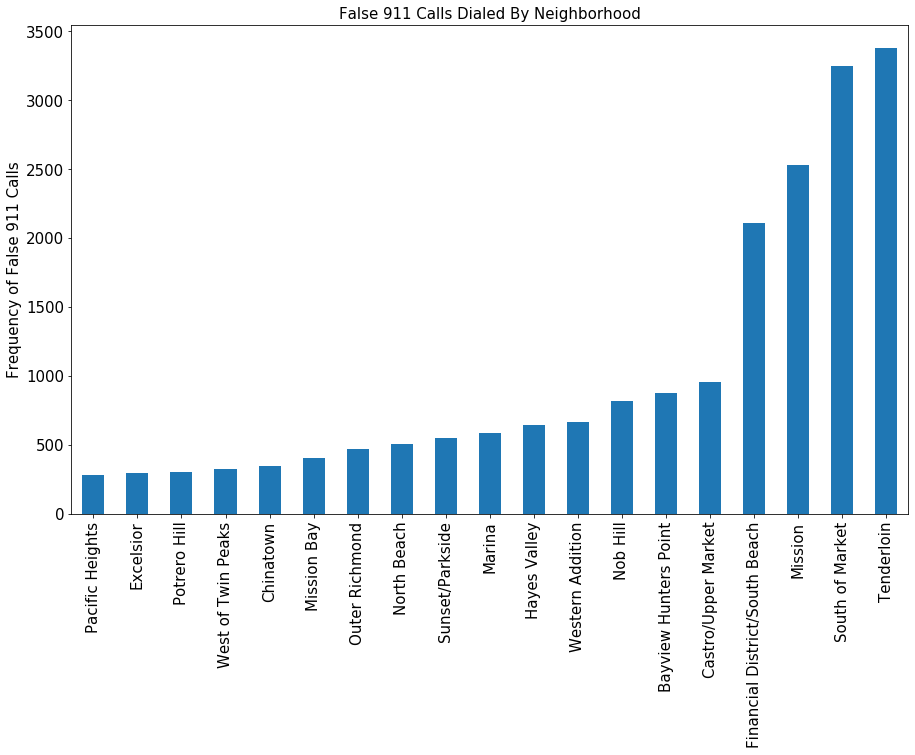

In [34]:

False_Call_df=Response_Df[Response_Df['Calls_WO_Merit']==1]

Top4 = False_Call_df["Neighborhooods - Analysis Boundaries"].value_counts()[1:5]
print(f"Analysis:\nTop 4 neighborhoods who called 911 also make up approximately {round(Top4.sum()/len(False_Call_df)*100,0)}% of False 911 calls.")

plt.figure(figsize=(15,9))
False_Call_df["Neighborhooods - Analysis Boundaries"].value_counts(ascending=True)[:-1].plot("bar")
plt.title("False 911 Calls Dialed By Neighborhood",fontsize=15)
plt.ylabel("Frequency of False 911 Calls",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

### 4B. Percentage of False Calls By Neighborhood

Analysis: 
So approximately the largest percentage of False 911 calls came from a neighborhood which dialed 911 only 6743 times overall.


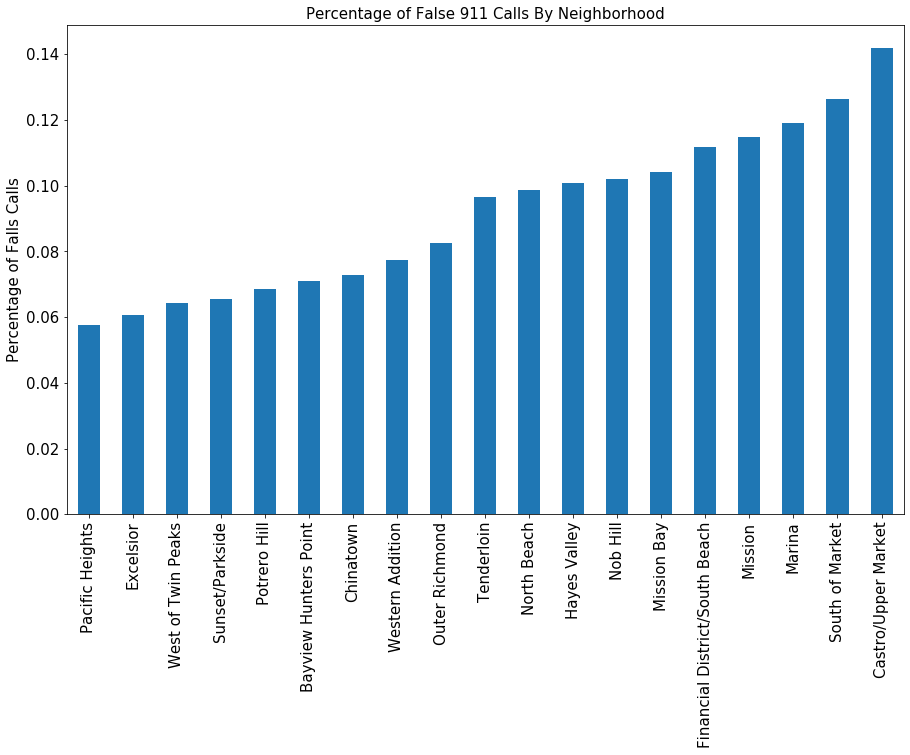

In [35]:
Percentage_of_False_Calls = Response_Df.groupby(["Neighborhooods - Analysis Boundaries"])["Calls_WO_Merit"].mean().sort_values().drop('All other < ~20%',axis=0)

Castro_911_Call=Response_Df['Neighborhooods - Analysis Boundaries'].value_counts(ascending=False).loc['Castro/Upper Market']

print(f"Analysis: \nSo approximately the largest percentage of False 911 calls came from a neighborhood which dialed 911 only {Castro_911_Call} times overall.")


plt.figure(figsize=(15,9))

Percentage_of_False_Calls.plot('bar')
plt.title("Percentage of False 911 Calls By Neighborhood",fontsize=15)
plt.ylabel("Percentage of Falls Calls",fontsize=15)
plt.xlabel('')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

### 4C. Frequency of False Calls by Time

Analysis: From this we can tell that False 911 calls are more likely to be made during the day. Day of the week is not a good indicator though.


<Figure size 1080x648 with 0 Axes>

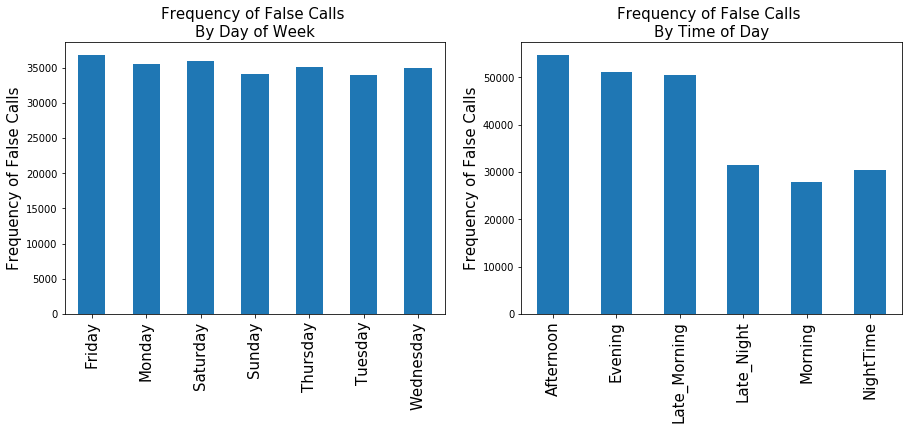

In [36]:
print("Analysis: From this we can tell that False 911 calls are more likely to be made during the day. Day of the week is not a good indicator though.")

plt.figure(figsize=(15,9))
fig, axes = plt.subplots(1,2, figsize=(15, 5))

Response_Df.groupby("WeekDay")["Calls_WO_Merit"].count().plot('bar',ax=axes[0])
Response_Df.groupby("Time_of_Day")["Calls_WO_Merit"].count().plot('bar',axes[1])

axes[0].set_title("Frequency of False Calls \nBy Day of Week",fontsize=15)
axes[0].set_ylabel("Frequency of False Calls",fontsize=15)
axes[0].set_xlabel('')
axes[0].set_xticklabels(axes[0].get_xmajorticklabels(),fontsize=15,rotation=90)

axes[1].set_title("Frequency of False Calls \nBy Time of Day",fontsize=15)
axes[1].set_ylabel("Frequency of False Calls",fontsize=15)
axes[1].set_xlabel('')
axes[1].set_xticklabels(axes[1].get_xmajorticklabels(),fontsize=15,rotation=90)

plt.show()

## 5. Analysis of Coordinates

In [37]:
print("Variance of continous features")
print(Response_Df[["Longitude","Latitude","Calls_WO_Merit"]].var())  
print("*"*115)
print("Even though variance of these continous features is extremely low (therefore making them a candidate for feature extraction), the nature of the feature (being coordinates) is such that we will not extract these features. We will take correlation of these features to assess for any multicollinearity")
print("*"*115)
Response_Df[["Longitude","Latitude","Calls_WO_Merit"]].corr()

Variance of continous features
Longitude         0.000562
Latitude          0.000701
Calls_WO_Merit    0.085365
dtype: float64
*******************************************************************************************************************
Even though variance of these continous features is extremely low (therefore making them a candidate for feature extraction), the nature of the feature (being coordinates) is such that we will not extract these features. We will take correlation of these features to assess for any multicollinearity
*******************************************************************************************************************


,Longitude,Latitude,Calls_WO_Merit
Longitude,1.000000,0.204826,0.038233
Latitude,0.204826,1.000000,0.029978
Calls_WO_Merit,0.038233,0.029978,1.000000


From the scatterplot, we can conclude that a high concentration of false 911 calls were made from the same geographical area


<Figure size 2160x864 with 0 Axes>

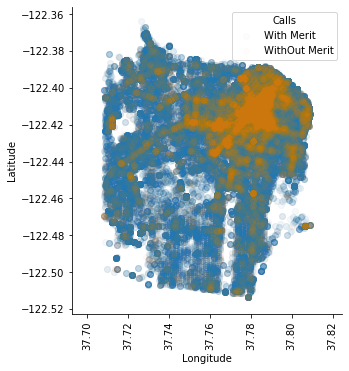

In [38]:
print("From the scatterplot, we can conclude that a high concentration of false 911 calls were made from the same geographical area")


plt.figure(figsize=(30,12))
sns.lmplot(x="Longitude",y="Latitude",data=Response_Df,hue="Calls_WO_Merit",scatter_kws={'alpha':.02},legend=False,fit_reg=False)
plt.xticks(rotation='vertical')
plt.legend(title='Calls', loc='upper right', labels=['With Merit', 'WithOut Merit'])
plt.show()

<Figure size 1080x648 with 0 Axes>

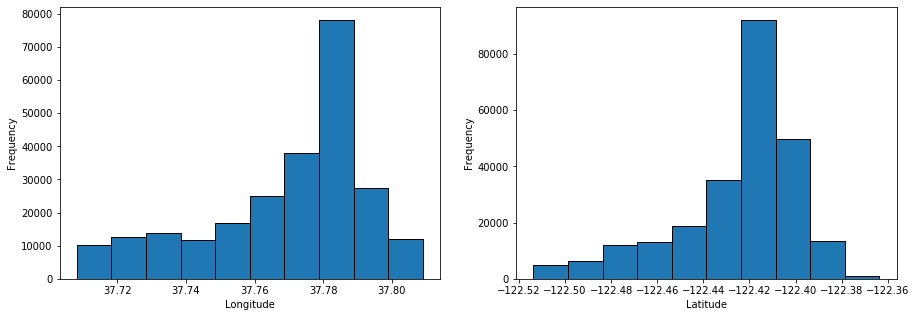

If we filter the dataframe to only those datapoints with false calls and the coordinates with the highest distribution as listed above, the neighborhoods listed below are the same as the ones we discussed earlier.

Tenderloin                        2854
Financial District/South Beach    2106
South of Market                   1321
All other < ~20%                  1127
Nob Hill                           818
Marina                             586
North Beach                        510
Western Addition                   500
Chinatown                          347
Pacific Heights                    287
Outer Richmond                     179
Hayes Valley                         7
Mission Bay                          4
Name: Neighborhooods - Analysis Boundaries, dtype: int64


In [39]:
plt.figure(figsize=(15,9))
fig, axes = plt.subplots(1,2, figsize=(15, 5))

Response_Df["Longitude"].plot.hist(edgecolor="black",ax=axes[0])
axes[0].set_xlabel("Longitude")
Response_Df["Latitude"].plot.hist(edgecolor="black",ax=axes[1])
axes[1].set_xlabel("Latitude")
plt.show()

#---------------------------------------------------------------------------------

False_calls=Response_Df["Calls_WO_Merit"]==1
Long=Response_Df["Longitude"]>37.78
Lat=Response_Df["Latitude"]<122.40

print("If we filter the dataframe to only those datapoints with false calls and the coordinates with the highest distribution as listed above, the neighborhoods listed below are the same as the ones we discussed earlier.\n")
print(Response_Df[(False_calls)&(Long)&(Lat)]['Neighborhooods - Analysis Boundaries'].value_counts())

## 6. Analysis of Target Distribution

In [40]:
Response_Df['Calls_WO_Merit'].value_counts()

0    223076
1     23212
Name: Calls_WO_Merit, dtype: int64

The Target Distribution is highly imbalanced. We will employ oversampling minority class techniques to balance the target class.


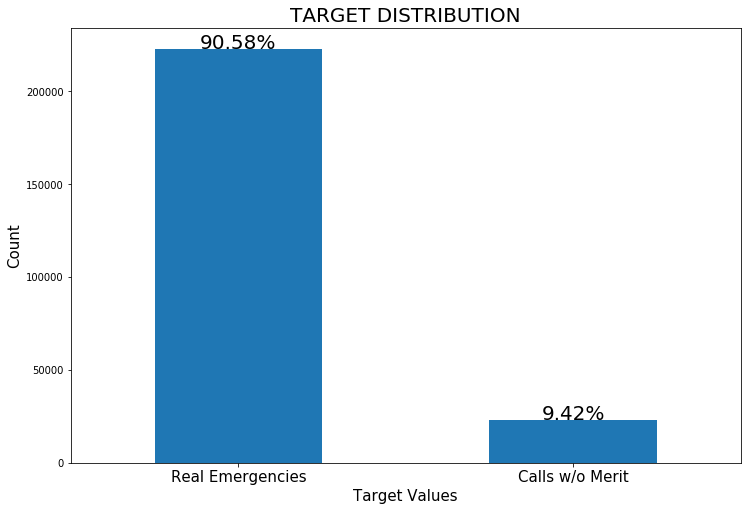

In [41]:
plt.figure(figsize=(12,8))
print("The Target Distribution is highly imbalanced. We will employ oversampling minority class techniques to balance the target class.")

#g = sns.countplot(x='Target', data=fire_df_visuals, color='green')
g=Response_Df['Calls_WO_Merit'].value_counts().plot('bar')
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Values", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
g.set_xticklabels(["Real Emergencies","Calls w/o Merit"], size=15,rotation='horizontal')



for p in g.patches:
    g.text( p.get_x()+p.get_width()/2,     p.get_height()+4,    '{:1.2f}%'.format(p.get_height()/len(Response_Df)*100), ha="center", fontsize=20) 

plt.show()

## 7. Statistical Analysis of Categorical Features to Target

**Calculating Chi2 pvalue to assess whether that particular categorical feature is independent of the target.**

In [42]:
# calculating chi2 for all categorical features

def crosstab_percentages(target,categorical_column):
    Target_Distribution=pd.crosstab(Response_Df[target],Response_Df[categorical_column])
    Target_Distribution_Percentage=Target_Distribution/Target_Distribution.sum()
    stat, p, dof, expected = sc.chi2_contingency(Target_Distribution)
    print(f"Chi_Squared p_value: {p:.3f} (stat:{stat:.2f},DoF:{dof})")
    return (Target_Distribution_Percentage.round(decimals=2)*100).astype(int).astype(str)+"%"

In [43]:
print('P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.\n\n')

crosstab_percentages("Calls_WO_Merit","Call Type")

P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.


Chi_Squared p_value: 0.000 (stat:5699.16,DoF:5)


Call Type,Alarms,All other < ~5%,Medical Incident,Outside Fire,Structure Fire,Traffic Collision
Calls_WO_Merit,,,,,,
0,99%,94%,88%,94%,98%,87%
1,1%,6%,12%,6%,2%,13%


In [44]:
print('P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.\n\n')

crosstab_percentages("Calls_WO_Merit","Neighborhooods - Analysis Boundaries")

P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.


Chi_Squared p_value: 0.000 (stat:1340.16,DoF:19)


Neighborhooods - Analysis Boundaries,All other < ~20%,Bayview Hunters Point,Castro/Upper Market,Chinatown,Excelsior,Financial District/South Beach,Hayes Valley,Marina,Mission,Mission Bay,Nob Hill,North Beach,Outer Richmond,Pacific Heights,Potrero Hill,South of Market,Sunset/Parkside,Tenderloin,West of Twin Peaks,Western Addition
Calls_WO_Merit,,,,,,,,,,,,,,,,,,,,
0,92%,93%,86%,93%,94%,89%,90%,88%,89%,90%,90%,90%,92%,94%,93%,87%,93%,90%,94%,92%
1,8%,7%,14%,7%,6%,11%,10%,12%,11%,10%,10%,10%,8%,6%,7%,13%,7%,10%,6%,8%


In [45]:
print('P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.\n\n')

crosstab_percentages("Calls_WO_Merit","WeekDay")

P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.


Chi_Squared p_value: 0.002 (stat:20.30,DoF:6)


WeekDay,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
Calls_WO_Merit,,,,,,,
0,90%,91%,90%,91%,91%,91%,91%
1,10%,9%,10%,9%,9%,9%,9%


In [46]:
print('P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.\n\n')

crosstab_percentages("Calls_WO_Merit","Seasons")

P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.


Chi_Squared p_value: 0.000 (stat:35.71,DoF:3)


Seasons,Fall,Spring,Summer,Winter
Calls_WO_Merit,,,,
0,91%,90%,91%,91%
1,9%,10%,9%,9%


In [47]:
print('P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.\n\n')

crosstab_percentages("Calls_WO_Merit","Time_of_Day")

P-value is less than .05 and therefore statistically significant. We can not say that this feature is independent of the target.


Chi_Squared p_value: 0.000 (stat:170.65,DoF:5)


Time_of_Day,Afternoon,Evening,Late_Morning,Late_Night,Morning,NightTime
Calls_WO_Merit,,,,,,
0,89%,91%,90%,92%,91%,91%
1,11%,9%,10%,8%,9%,9%


## 8. Modeling

In [48]:
#setting dummy variables
model_df = pd.get_dummies(Response_Df,drop_first=True)
model_df.head()

,Calls_WO_Merit,Longitude,Latitude,Response_Time,Call Type_All other < ~5%,Call Type_Medical Incident,Call Type_Outside Fire,Call Type_Structure Fire,Call Type_Traffic Collision,Neighborhooods - Analysis Boundaries_Bayview Hunters Point,Neighborhooods - Analysis Boundaries_Castro/Upper Market,Neighborhooods - Analysis Boundaries_Chinatown,Neighborhooods - Analysis Boundaries_Excelsior,Neighborhooods - Analysis Boundaries_Financial District/South Beach,Neighborhooods - Analysis Boundaries_Hayes Valley,Neighborhooods - Analysis Boundaries_Marina,Neighborhooods - Analysis Boundaries_Mission,Neighborhooods - Analysis Boundaries_Mission Bay,Neighborhooods - Analysis Boundaries_Nob Hill,Neighborhooods - Analysis Boundaries_North Beach,Neighborhooods - Analysis Boundaries_Outer Richmond,Neighborhooods - Analysis Boundaries_Pacific Heights,Neighborhooods - Analysis Boundaries_Potrero Hill,Neighborhooods - Analysis Boundaries_South of Market,Neighborhooods - Analysis Boundaries_Sunset/Parkside,Neighborhooods - Analysis Boundaries_Tenderloin,Neighborhooods - Analysis Boundaries_West of Twin Peaks,Neighborhooods - Analysis Boundaries_Western Addition,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday,Seasons_Spring,Seasons_Summer,Seasons_Winter,Time_of_Day_Evening,Time_of_Day_Late_Morning,Time_of_Day_Late_Night,Time_of_Day_Morning,Time_of_Day_NightTime
0,0,37.801325,-122.453498,9.25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0,37.745956,-122.454240,8.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
3,0,37.710878,-122.409122,14.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
4,0,37.788316,-122.411855,5.00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0
5,0,37.729302,-122.390877,16.00,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0


In [49]:
#setting up dependent and independent variables
y=model_df["Calls_WO_Merit"]
X=model_df.drop("Calls_WO_Merit",axis=1)

In [50]:
#trian test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=2)

### 8A. Balancing Target Classes
- Based on Target Class distribution above, we know that the target class is highly imbalanced (90/10). Hence for our models to work properly, we will oversample the minority class. 
- Note we will only over-sample the training data leaving the test data unaltered so it can give us a valid metric of the model.
- Because the target class is so imbalanced, we will focus on the "recall" score. Recall score is focused on driving down Type II or False Negatives error.

In [51]:
from sklearn.utils import resample

# concatenate training data back together to address target imbalance
Training_Data = pd.concat([X_train,y_train],axis=1)


#Seperating Minority and Majority Class for statistical comparison purposes (Chi2)

#Majority Class
TD_Maj = Training_Data[Training_Data["Calls_WO_Merit"]==0]

#Minority Class
TD_Min = Training_Data[Training_Data["Calls_WO_Merit"]==1]

#Balancing target - feed it Minority Class and the length of Majority CLass
Unsampled = resample(TD_Min,replace=True,n_samples=(len(TD_Maj)),random_state=40)

# combine majority and upsampled minority
TD_Rebalanced = pd.concat([TD_Maj, Unsampled])


print(TD_Rebalanced["Calls_WO_Merit"].value_counts())

TD_Rebalanced.head()

1    156174
0    156174
Name: Calls_WO_Merit, dtype: int64


,Longitude,Latitude,Response_Time,Call Type_All other < ~5%,Call Type_Medical Incident,Call Type_Outside Fire,Call Type_Structure Fire,Call Type_Traffic Collision,Neighborhooods - Analysis Boundaries_Bayview Hunters Point,Neighborhooods - Analysis Boundaries_Castro/Upper Market,Neighborhooods - Analysis Boundaries_Chinatown,Neighborhooods - Analysis Boundaries_Excelsior,Neighborhooods - Analysis Boundaries_Financial District/South Beach,Neighborhooods - Analysis Boundaries_Hayes Valley,Neighborhooods - Analysis Boundaries_Marina,Neighborhooods - Analysis Boundaries_Mission,Neighborhooods - Analysis Boundaries_Mission Bay,Neighborhooods - Analysis Boundaries_Nob Hill,Neighborhooods - Analysis Boundaries_North Beach,Neighborhooods - Analysis Boundaries_Outer Richmond,Neighborhooods - Analysis Boundaries_Pacific Heights,Neighborhooods - Analysis Boundaries_Potrero Hill,Neighborhooods - Analysis Boundaries_South of Market,Neighborhooods - Analysis Boundaries_Sunset/Parkside,Neighborhooods - Analysis Boundaries_Tenderloin,Neighborhooods - Analysis Boundaries_West of Twin Peaks,Neighborhooods - Analysis Boundaries_Western Addition,WeekDay_Monday,WeekDay_Saturday,WeekDay_Sunday,WeekDay_Thursday,WeekDay_Tuesday,WeekDay_Wednesday,Seasons_Spring,Seasons_Summer,Seasons_Winter,Time_of_Day_Evening,Time_of_Day_Late_Morning,Time_of_Day_Late_Night,Time_of_Day_Morning,Time_of_Day_NightTime,Calls_WO_Merit
240196,37.786117,-122.419854,9.25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
214792,37.784911,-122.499515,7.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
209400,37.783575,-122.493004,7.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
268034,37.782557,-122.416349,6.00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
49506,37.785672,-122.419621,9.25,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0


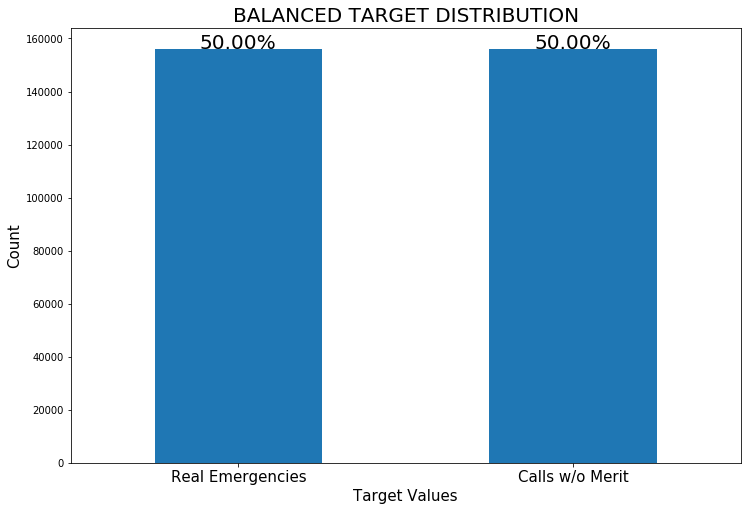

In [52]:
plt.figure(figsize=(12,8))

g=TD_Rebalanced['Calls_WO_Merit'].value_counts().plot('bar')
g.set_title("BALANCED TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Values", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
g.set_xticklabels(["Real Emergencies","Calls w/o Merit"], size=15,rotation='horizontal')


for p in g.patches:
    g.text( p.get_x()+p.get_width()/2,     p.get_height()+4,    '{:1.2f}%'.format(p.get_height()/len(TD_Rebalanced)*100), ha="center", fontsize=20) 

plt.show()

In [53]:
#Breaking out rebalaned training data 

y_train = TD_Rebalanced['Calls_WO_Merit']

X_train = TD_Rebalanced.drop('Calls_WO_Merit',axis=1)

### 4B. BASELINE - LOGISTIC REGRESSION

In [54]:
lrc=LogisticRegression(random_state=1)  # default C=1, penalty =l2 (Ridge)
lrc.fit(X_train,y_train)
y_pred=lrc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

LogReg=round(recall_score(y_test, y_pred, average='binary'),2)

cross_val_score(lrc, X_train, y_train, cv=5, scoring='recall')

col_0               0      1
Calls_WO_Merit              
0               30416  36486
1                1442   5543
**************************************************
Recall is:0.79
**************************************************


array([0.79116376, 0.80576277, 0.80112054, 0.8037458 , 0.80217071])

**Comments**: Metrics from the Confusion matrix are relatively low. However, we will focus on the recall score which gives us a score of .79. Because we really want to minimize Type 2 error, we will look for another algorithm with less False negatives and a better recall score.

### 4C. BAGGING ALGORITHM (Parallel Learners - Random Forest)**  ###

In [55]:
rfc=RandomForestClassifier(random_state=1)  #n_estimators = 10, max_depth=none   max_features = sqrt(# of features),  min_leaf =1,  min_split =2
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

Random_Forest=round(recall_score(y_test, y_pred, average='binary'),2)

#cross validation can only be done on the oversampled minority class database. It can not be done on the original unaltered dataset because its dimensions are different (due to the fact that minority classess were subsequently added to the dataset)
cross_val_score(rfc, X_train, y_train, cv=5, scoring='recall')

col_0               0     1
Calls_WO_Merit             
0               65146  1756
1                4487  2498
**************************************************
Recall is:0.36
**************************************************


array([0.99977589, 0.99923163, 0.99939171, 0.99967985, 0.99865531])

**Comments**:: At first glance, there seems to be something wrong with out model. Its accuracy is high but recall score is much lower at 38%. However, its cross validation of the dataset reveals an almost 100% recall score. 

Lastly, we scrutinized the default parameters and noticed that the depth of the tree is not indicated, the min_samples_split is 2 and the min_samples_leaf is 1! In short, it is a very long tree. Because our dataset is relatively small, it is not computation-expensive to have such a long tree with a leaf of 1. However if our dataset was much larger, it would be very memory-intensive to generate such a tree on a scale indicated by the number of trees parameter. 

To anticipate larger datasets, we will now employ the same model but we will tune in the hyperparameters resulting in a bit more variance and lower scoring metrics.

**Random Forest - tuning parameters**

In [56]:
rfc=RandomForestClassifier(n_estimators=100, min_samples_split=40, min_samples_leaf=20,max_depth=10,random_state=1)  #n_estimators = 10, max_depth=none   max_features = sqrt(# of features),  min_leaf =1,  min_split =2
rfc.fit(X_train,y_train)
y_pred=rfc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

Random_Forest_tuned=round(recall_score(y_test, y_pred, average='binary'),2)

cross_val_score(rfc, X_train, y_train, cv=5, scoring='recall')

col_0               0      1
Calls_WO_Merit              
0               42017  24885
1                1994   4991
**************************************************
Recall is:0.71
**************************************************


array([0.7314551 , 0.75047223, 0.73555307, 0.75690732, 0.7259717 ])

**Comments**: Based on rule-of-thumb parameters tuning, our recall score is 71% - which is still lower than the original 79% we got from Basic Logistic Regression. Let's try boosting algorithms to see if we can get a better score.

### **4D. BOOSTING ALGORITHM (Sequential Learners)**  ###

**GradientBoosting Classifer**

In [57]:

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=.1, min_samples_split=40, min_samples_leaf=20,max_depth=10,random_state=1)
gbc.fit(X_train,y_train)
y_pred=gbc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))
print("*"*50)

Grad_Boost_I=round(recall_score(y_test, y_pred, average='binary'),2)

col_0               0      1
Calls_WO_Merit              
0               53239  13663
1                2369   4616
**************************************************
Recall is:0.66
**************************************************


**Comments**: We used the same parameters as Random Forest with the default learning rate set to .1. Given that is is a boosting algorithm, we wanted to limit the estimator parameter to 100. After trying various learning rates, we settled on a learning rate of .1

**AdaBoost**

In [58]:
abc = AdaBoostClassifier(n_estimators=100, learning_rate=1,random_state=1)
abc.fit(X_train,y_train)
y_pred=abc.predict(X_test)
print(pd.crosstab(y_test,y_pred))
print("*"*50)
print('Recall is:'+str(round(recall_score(y_test, y_pred, average='binary'),2)))

print("*"*50)

AdaBoost=round(recall_score(y_test, y_pred, average='binary'),2)

col_0               0      1
Calls_WO_Merit              
0               44783  22119
1                2364   4621
**************************************************
Recall is:0.66
**************************************************


**Comments**: Our recall score is still less than the original baseline Logistic Regression

### **4E. FEATURE IMPORTANCE**  ###
- We will extract the most important features and then use Logistic Regression again to assess whether we can get a better recall score than the original 79%.

(array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
        0.225]), <a list of 10 Text yticklabel objects>)

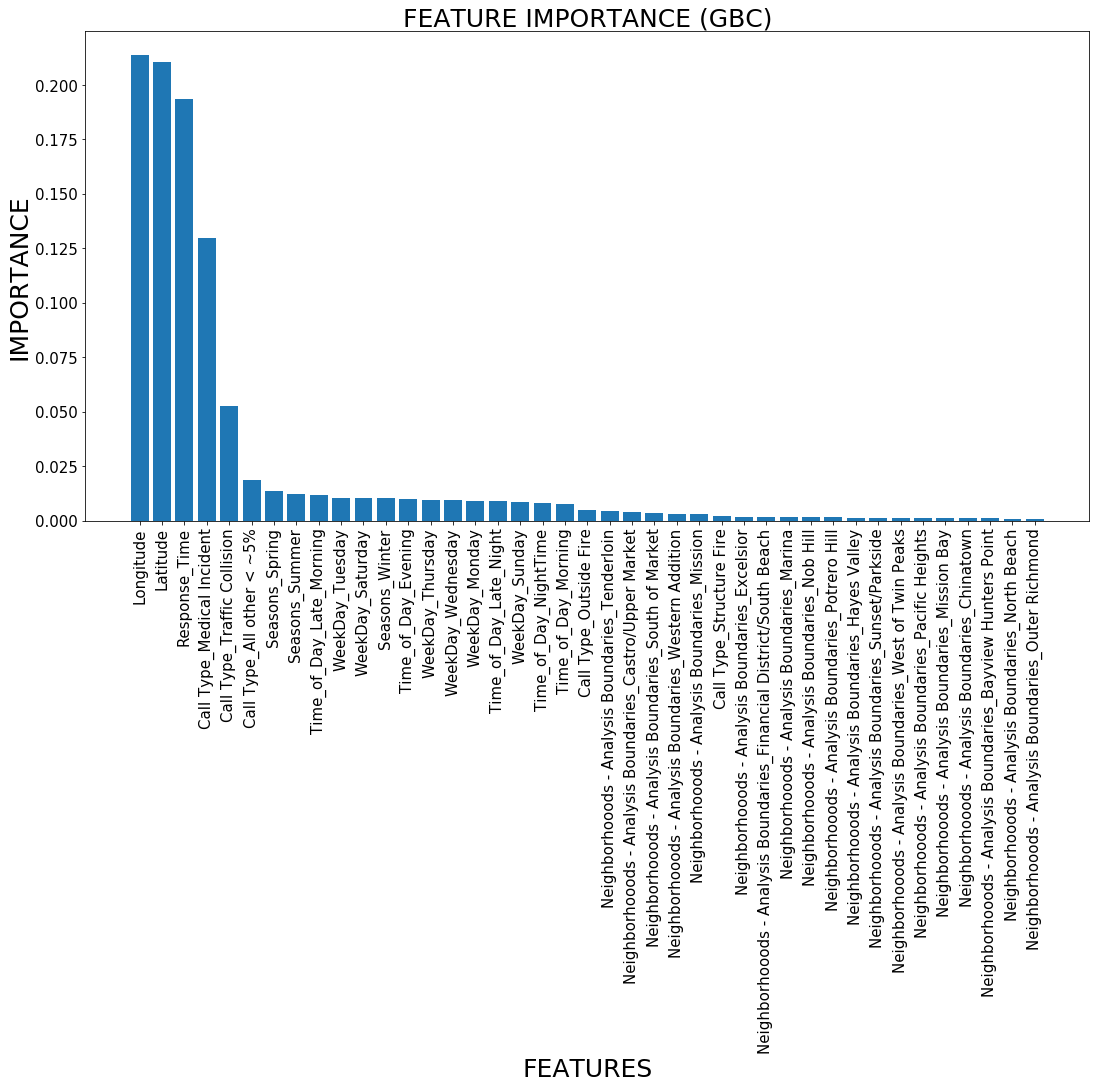

In [59]:
Importance=gbc.feature_importances_
Columns=X_train.columns

Importance,Columns=zip(*sorted(zip(Importance, Columns),reverse=True))


plt.figure(figsize=(18,9))
plt.xticks(rotation="vertical")
plt.bar(x=Columns,height=Importance)
plt.ylabel('IMPORTANCE',fontsize=25)
plt.xlabel('FEATURES',fontsize=25)
plt.title("FEATURE IMPORTANCE (GBC)",fontsize=25)
plt.xticks(rotation='vertical',fontsize=15)
plt.yticks(fontsize=15)

**Retrieving features that that make upto 90% of importance level. This would reduce the dataset to only 13 dimensions.**

In [60]:
Importance=np.array(Importance)

#retrieving the first index where the cumulative sum exceeds 90%
index_90=np.where(Importance.cumsum()>.90)[0][0] 

print(Importance.cumsum())
print("*"*100)
print(f"index position where feature importance cumulutuve sum total exceeds 90%: {index_90}")

[0.21376548 0.42433309 0.6176901  0.74728793 0.79999858 0.81872393
 0.83248059 0.84477991 0.8563029  0.86675746 0.87719146 0.88738474
 0.89713591 0.90656774 0.91579896 0.92475266 0.93361428 0.94197017
 0.95007658 0.95773876 0.96272903 0.96723267 0.9711258  0.97478941
 0.97786469 0.98083472 0.98280261 0.98465151 0.98623595 0.98781101
 0.98935727 0.99078996 0.99204658 0.99329926 0.9945152  0.99560019
 0.99667579 0.99771929 0.99867688 0.99944036 1.        ]
****************************************************************************************************
index position where feature importance cumulutuve sum total exceeds 90%: 13


### **4F. LOGISTIC REGRESSION - AFTER FEATURE EXTRACTION**  ###

In [61]:
#Setting up new dataframe with features that make up 90% of the value

y=model_df["Calls_WO_Merit"]

X_revised=model_df[list(Columns[:index_90])]

In [62]:
#Splitting new revised dataset between training and test data

X_train_rev, X_test_rev, y_train_rev, y_test_rev = train_test_split(X_revised, y, test_size=0.30,random_state=2)

print(len(X_train_rev))
print(len(X_test_rev))
print(len(y_train_rev))
print(len(y_test_rev))

172401
73887
172401
73887


In [63]:
from sklearn.utils import resample

# concatenate training data back together to address target imbalance
Training_Data_rev = pd.concat([X_train_rev,y_train_rev],axis=1)


#Seperating Minority and Majority Class for statistical comparison purposes (Chi2)

#Majority Class
TD_Maj_rev = Training_Data_rev[Training_Data_rev["Calls_WO_Merit"]==0]

#Minority Class
TD_Min_rev = Training_Data_rev[Training_Data_rev["Calls_WO_Merit"]==1]

#Balancing target - feed it Minority Class and the length of Majority CLass
Unsampled_rev = resample(TD_Min_rev,replace=True,n_samples=(len(TD_Maj_rev)),random_state=40)

# combine majority and upsampled minority
TD_Rebalanced_rev = pd.concat([TD_Maj_rev, Unsampled_rev])


print(TD_Rebalanced_rev["Calls_WO_Merit"].value_counts())

TD_Rebalanced_rev.head()

1    156174
0    156174
Name: Calls_WO_Merit, dtype: int64


,Longitude,Latitude,Response_Time,Call Type_Medical Incident,Call Type_Traffic Collision,Call Type_All other < ~5%,Seasons_Spring,Seasons_Summer,Time_of_Day_Late_Morning,WeekDay_Tuesday,WeekDay_Saturday,Seasons_Winter,Time_of_Day_Evening,Calls_WO_Merit
240196,37.786117,-122.419854,9.25,1,0,0,0,0,0,0,0,0,0,0
214792,37.784911,-122.499515,7.00,0,0,0,0,0,0,0,1,0,0,0
209400,37.783575,-122.493004,7.00,0,0,0,0,0,0,0,1,0,0,0
268034,37.782557,-122.416349,6.00,0,0,0,0,0,0,0,0,0,0,0
49506,37.785672,-122.419621,9.25,1,0,0,0,0,0,0,1,1,0,0


In [64]:
#Breaking out rebalaned training data 

y_train_rev = TD_Rebalanced_rev['Calls_WO_Merit']

X_train_rev = TD_Rebalanced_rev.drop('Calls_WO_Merit',axis=1)

# X_train_rev, X_test_rev, y_train_rev, y_test_rev

print(len(X_train_rev))
print(len(X_test_rev))
print(len(y_train_rev))
print(len(y_test_rev))

312348
73887
312348
73887


In [65]:
lrc_rev = LogisticRegression(random_state=1)  # default C=1, penalty =l2 (Ridge)
lrc_rev.fit(X_train_rev,y_train_rev)
y_pred_rev=lrc_rev.predict(X_test_rev)
print(pd.crosstab(y_test_rev,y_pred_rev))
print("*"*50)
print('Recall is:'+str(round(recall_score(y_test_rev, y_pred_rev, average='binary'),2)))
print("*"*50)

LogReg_II=round(recall_score(y_test_rev, y_pred_rev, average='binary'),2)

cross_val_score(lrc_rev, X_train_rev, y_train_rev, cv=5, scoring='recall')

col_0               0      1
Calls_WO_Merit              
0               25972  40930
1                 994   5991
**************************************************
Recall is:0.86
**************************************************


array([0.85151273, 0.8623019 , 0.85692332, 0.85884425, 0.8599603 ])

## **9. CONCLUSION**  ##

In [66]:
Classifers=['Log_Reg', 'Random_Forest(no tuning)', 'Random_Forest(tuned)', "Grad_Boost(tuned)", "AdaBoost","Log_Reg_II(w_FI)" ]

Scores=[LogReg, Random_Forest, Random_Forest_tuned, Grad_Boost_I, AdaBoost, LogReg_II]

Scores_df=pd.DataFrame(list(zip(Classifers,Scores)),columns=["Classifiers","Scores"])

Scores_df.set_index("Classifiers",drop=True,inplace=True)

Scores_df.sort_values("Scores",inplace=True)

Scores_df

,Scores
Classifiers,
Random_Forest(no tuning),0.36
Grad_Boost(tuned),0.66
AdaBoost,0.66
Random_Forest(tuned),0.71
Log_Reg,0.79
Log_Reg_II(w_FI),0.86


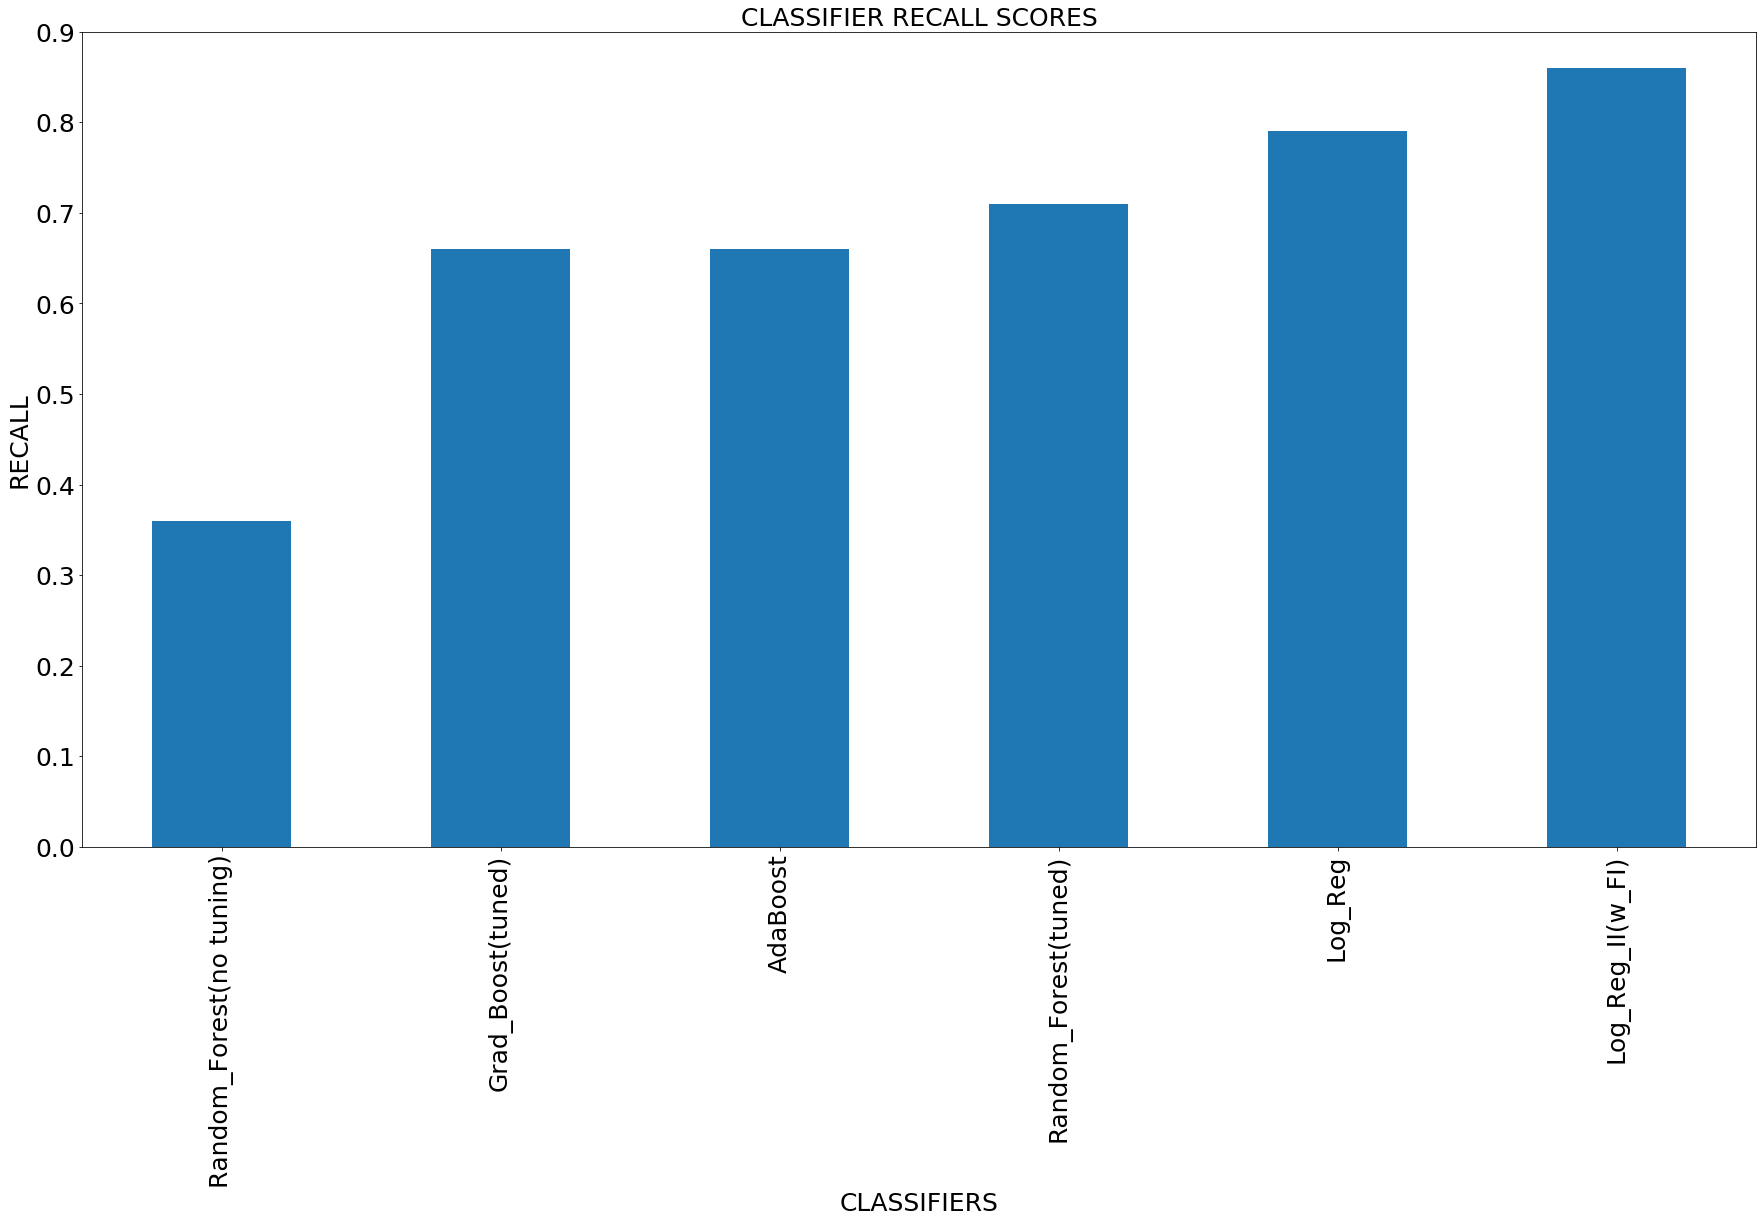

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(30,15)


Scores_df["Scores"].plot('bar',ax=ax)
plt.ylabel('RECALL',fontsize=25)
plt.xlabel('CLASSIFIERS',fontsize=25)
plt.title("CLASSIFIER RECALL SCORES",fontsize=25)
plt.xticks(rotation='vertical',fontsize=25)
plt.yticks(fontsize=25)
plt.ylim(0.00,.90)
plt.show()

### 9A. WINNER ###

**Winner : Logistic Regression (*after Feature Importance)**. After reducing the dimensions using the feature importance method from ensembler algorithms, we were able to achieve a 86% recall score with a simple Logistic Regression model.